In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/MyDrive/sentimentdataset.csv' # Update this path
df = pd.read_csv(file_path)

# Soial Media Sentiment Analysis

## Import libraries

In [ ]:
!pip install -qq transformers

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
from wordcloud import WordCloud

nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

from sklearn.preprocessing import LabelEncoder

#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModel

import torch
from torch import nn, optim
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from collections import defaultdict

from tqdm import tqdm


import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Overview

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  732 non-null    int64  
 1   Unnamed: 0    732 non-null    int64  
 2   Text          732 non-null    object 
 3   Sentiment     732 non-null    object 
 4   Timestamp     732 non-null    object 
 5   User          732 non-null    object 
 6   Platform      732 non-null    object 
 7   Hashtags      732 non-null    object 
 8   Retweets      732 non-null    float64
 9   Likes         732 non-null    float64
 10  Country       732 non-null    object 
 11  Year          732 non-null    int64  
 12  Month         732 non-null    int64  
 13  Day           732 non-null    int64  
 14  Hour          732 non-null    int64  
dtypes: float64(2), int64(6), object(7)
memory usage: 85.9+ KB


732 entries, not a large dataset

In [ ]:
df.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


## Data Cleaning

Notice two columns are missing appropirate labels, need to label all columns with meanings and drop duplicate ones.

In [ ]:
# rename columns 'unamed' to 'id'
df.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
# drop remaining column 'unamed: 0.1'
df.drop(columns=['Unnamed: 0.1'], inplace=True)
# reset index as column 'id'
df.set_index('id', inplace=True)

In [ ]:
df.head()

,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
id,,,,,,,,,,,,,
0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [ ]:
# check for missing values
df.isnull().sum()

,0
Text,0
Sentiment,0
Timestamp,0
User,0
Platform,0
Hashtags,0
Retweets,0
Likes,0
Country,0
Year,0


NULL check: no NULL value

In [ ]:
# check for duplicates
df.duplicated().sum()

np.int64(20)

Duplicate check: 20 duplicate values, need to eliminate

In [ ]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 0 to 736
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Text       712 non-null    object 
 1   Sentiment  712 non-null    object 
 2   Timestamp  712 non-null    object 
 3   User       712 non-null    object 
 4   Platform   712 non-null    object 
 5   Hashtags   712 non-null    object 
 6   Retweets   712 non-null    float64
 7   Likes      712 non-null    float64
 8   Country    712 non-null    object 
 9   Year       712 non-null    int64  
 10  Month      712 non-null    int64  
 11  Day        712 non-null    int64  
 12  Hour       712 non-null    int64  
dtypes: float64(2), int64(4), object(7)
memory usage: 77.9+ KB


In [ ]:
# make sure all timestamps are in datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
# create a col to find out the day of the week for each timestamp
df['Day_of_Week'] = df['Timestamp'].dt.day_name()
df['Month'] = df['Timestamp'].dt.month_name()

In [ ]:
df['Country'].value_counts()

,count
Country,
USA,59
USA,51
UK,49
Canada,44
Australia,36
...,...
Ireland,1
Scotland,1
Kenya,1


USA is counted twice, need to trim for accuracy

In [ ]:
# convert all texts to lowercase & strip the white spaces in the 'Platform' column
df['Country'] = df['Country'].str.lower()
df['Country'] = df['Country'].str.strip()
df['Country'].value_counts()

,count
Country,
usa,184
uk,140
canada,132
australia,70
india,68
brazil,17
france,16
japan,15
germany,14


In [ ]:
# convert all texts to lowercase & strip the white spaces in the 'Platform' column
df['Platform'] = df['Platform'].str.lower()
df['Platform'] = df['Platform'].str.strip()
df['Platform'].value_counts()

,count
Platform,
instagram,252
twitter,236
facebook,224


In [ ]:
# list out all sentiments
pd.set_option('display.max_rows', None)
df['Sentiment'].value_counts()

,count
Sentiment,
Positive,44
Joy,42
Excitement,32
Neutral,14
Happy,14
Contentment,13
Gratitude,9
Sad,9
Curiosity,8


Noticed some sentiments are counted twice, need to trim data for accuracy

In [ ]:
# convert all texts to lowercase & strip the white spaces in the 'Sentiment' column
df['Sentiment'] = df['Sentiment'].str.lower()
df['Sentiment'] = df['Sentiment'].str.strip()
df['Sentiment'].value_counts().shape

(191,)

Now there are over 190 distinct sentiments in our dataset.

In [ ]:
# count the top 10 most frequent words in the 'Sentiment' column
pd.set_option('display.max_rows', None)
df['Sentiment'].value_counts()

,count
Sentiment,
positive,45
joy,44
excitement,37
contentment,18
neutral,18
gratitude,17
curiosity,16
serenity,15
happy,14


Text(0.5, 1.0, 'Top 10 sentiments on Social Media')

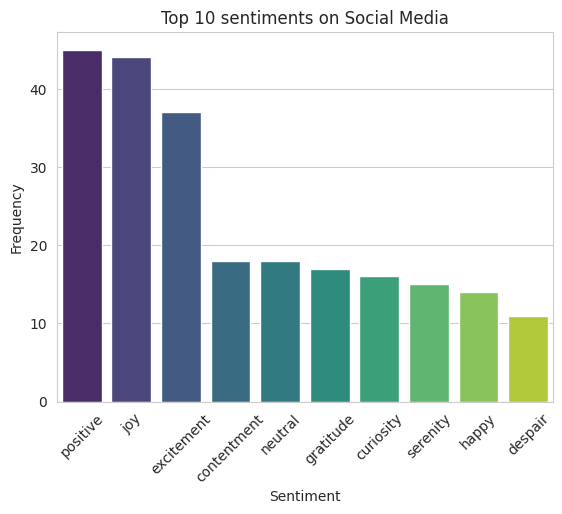

In [ ]:
# Visualize the top 10 most frequent words in the 'Sentiment' column, and order by frequency in descending order
sns.set_style('whitegrid')
sns.countplot(x='Sentiment', data=df, order=df['Sentiment'].value_counts().index[:10], palette='viridis')
plt.xticks(rotation=45)
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Top 10 sentiments on Social Media')

There are over 190 sentiments in total, and top sentiments include: positive, joy, excitement....

## Nature of Sentiment Analysis (attributing to'positive', 'negative', 'neutral')

Many sentiments are listed in the dataset, but can they be categorized into three main sentiment groups: positive, neural, and negative?

In [ ]:
df1 = df.copy()

In [ ]:
# first analyze 'sentiment' column's sentiment using Vader and give each sentiment a score
analyzer = SentimentIntensityAnalyzer()
df1['Sentiment_Score'] = df1['Sentiment'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
# based on the sentiment score of each sentiment, if 'compound' score is >= 0.05, then it is positive, if <= -0.05, then it is negative, else it is neutral
df1['Sentiment_Nature'] = df1['Sentiment_Score'].apply(lambda x: 'positive' if x >= 0.05 else 'negative' if x <= -0.05 else 'neutral')
df1.head(60)

,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour,Day_of_Week,Sentiment_Score,Sentiment_Nature
id,,,,,,,,,,,,,,,,
0,Enjoying a beautiful day at the park! ...,positive,2023-01-15 12:30:00,User123,twitter,#Nature #Park,15.0,30.0,usa,2023,January,15,12,Sunday,0.5574,positive
1,Traffic was terrible this morning. ...,negative,2023-01-15 08:45:00,CommuterX,twitter,#Traffic #Morning,5.0,10.0,canada,2023,January,15,8,Sunday,-0.5719,negative
2,Just finished an amazing workout! 💪 ...,positive,2023-01-15 15:45:00,FitnessFan,instagram,#Fitness #Workout,20.0,40.0,usa,2023,January,15,15,Sunday,0.5574,positive
3,Excited about the upcoming weekend getaway! ...,positive,2023-01-15 18:20:00,AdventureX,facebook,#Travel #Adventure,8.0,15.0,uk,2023,January,15,18,Sunday,0.5574,positive
4,Trying out a new recipe for dinner tonight. ...,neutral,2023-01-15 19:55:00,ChefCook,instagram,#Cooking #Food,12.0,25.0,australia,2023,January,15,19,Sunday,0.0000,neutral
5,Feeling grateful for the little things in lif...,positive,2023-01-16 09:10:00,GratitudeNow,twitter,#Gratitude #PositiveVibes,25.0,50.0,india,2023,January,16,9,Monday,0.5574,positive
6,Rainy days call for cozy blankets and hot coc...,positive,2023-01-16 14:45:00,RainyDays,facebook,#RainyDays #Cozy,10.0,20.0,canada,2023,January,16,14,Monday,0.5574,positive
7,The new movie release is a must-watch! ...,positive,2023-01-16 19:30:00,MovieBuff,instagram,#MovieNight #MustWatch,15.0,30.0,usa,2023,January,16,19,Monday,0.5574,positive
8,Political discussions heating up on the timel...,negative,2023-01-17 08:00:00,DebateTalk,twitter,#Politics #Debate,30.0,60.0,usa,2023,January,17,8,Tuesday,-0.5719,negative


Does the 'text' column have the same sentiment nature as the 'Sentiment' column? <br>
We need to analyze text sentiment and see the original text itself aligns with labeled sentiment.

In [ ]:
# preprocess text by removing punctuation(other than ? and ! and emojis), stopwords, and converting all texts to lowercase
# define punctuation and stopwords
punctuation = '"#$%&\'()*+,-./:;<=>@[\\]^_`{|}~'
# nltk's stopwords can be found @ https://gist.github.com/sebleier/554280
stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
# ensure all values in the 'Text' column are strings
df1['Text'] = df1['Text'].astype(str)

# remove punctuation (except '?' and '!'), convert to lowercase, and remove stopwords
df1['Cleaned_Text'] = df1['Text'].apply(lambda x: re.sub(f"[{re.escape(punctuation)}]", '', x).lower())
df1['Cleaned_Text'] = df1['Cleaned_Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
df1['Cleaned_Text'].head()

,Cleaned_Text
id,
0,enjoying beautiful day park!
1,traffic terrible morning
2,finished amazing workout! 💪
3,excited upcoming weekend getaway!
4,trying new recipe dinner tonight


In [ ]:
# analyze 'Cleaned_Text' column's sentiment using Vader and give each sentiment a score
df1['Text_Sentiment_Score'] = df1['Cleaned_Text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df1['Text_Sentiment_Nature'] = df1['Text_Sentiment_Score'].apply(lambda x: 'positive' if x >= 0.05 else 'negative' if x <= -0.05 else 'neutral')
df1.head(60)

,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour,Day_of_Week,Sentiment_Score,Sentiment_Nature,Cleaned_Text,Text_Sentiment_Score,Text_Sentiment_Nature
id,,,,,,,,,,,,,,,,,,,
0,Enjoying a beautiful day at the park! ...,positive,2023-01-15 12:30:00,User123,twitter,#Nature #Park,15.0,30.0,usa,2023,January,15,12,Sunday,0.5574,positive,enjoying beautiful day park!,0.8221,positive
1,Traffic was terrible this morning. ...,negative,2023-01-15 08:45:00,CommuterX,twitter,#Traffic #Morning,5.0,10.0,canada,2023,January,15,8,Sunday,-0.5719,negative,traffic terrible morning,-0.4767,negative
2,Just finished an amazing workout! 💪 ...,positive,2023-01-15 15:45:00,FitnessFan,instagram,#Fitness #Workout,20.0,40.0,usa,2023,January,15,15,Sunday,0.5574,positive,finished amazing workout! 💪,0.6239,positive
3,Excited about the upcoming weekend getaway! ...,positive,2023-01-15 18:20:00,AdventureX,facebook,#Travel #Adventure,8.0,15.0,uk,2023,January,15,18,Sunday,0.5574,positive,excited upcoming weekend getaway!,0.4003,positive
4,Trying out a new recipe for dinner tonight. ...,neutral,2023-01-15 19:55:00,ChefCook,instagram,#Cooking #Food,12.0,25.0,australia,2023,January,15,19,Sunday,0.0000,neutral,trying new recipe dinner tonight,0.0000,neutral
5,Feeling grateful for the little things in lif...,positive,2023-01-16 09:10:00,GratitudeNow,twitter,#Gratitude #PositiveVibes,25.0,50.0,india,2023,January,16,9,Monday,0.5574,positive,feeling grateful little things life,0.5423,positive
6,Rainy days call for cozy blankets and hot coc...,positive,2023-01-16 14:45:00,RainyDays,facebook,#RainyDays #Cozy,10.0,20.0,canada,2023,January,16,14,Monday,0.5574,positive,rainy days call cozy blankets hot cocoa,-0.0772,negative
7,The new movie release is a must-watch! ...,positive,2023-01-16 19:30:00,MovieBuff,instagram,#MovieNight #MustWatch,15.0,30.0,usa,2023,January,16,19,Monday,0.5574,positive,new movie release mustwatch!,0.0000,neutral
8,Political discussions heating up on the timel...,negative,2023-01-17 08:00:00,DebateTalk,twitter,#Politics #Debate,30.0,60.0,usa,2023,January,17,8,Tuesday,-0.5719,negative,political discussions heating timeline,0.0000,neutral


In [ ]:
# compare how many rows have the same sentiment nature based on texts and labeled sentiments
correct_label = df1[df1['Sentiment_Nature'] == df1['Text_Sentiment_Nature']].shape[0]

# calculate the pencentage of correct labels
total_rows = df1.shape[0]
correct_label = (correct_label / total_rows) * 100
correct_label

71.20786516853933

Based on sentimet nature score of texts and labeled sentiments, **71.2%** sentiment data are labeled appropriately in nature(positive, negative, neutral), with only a few exception.

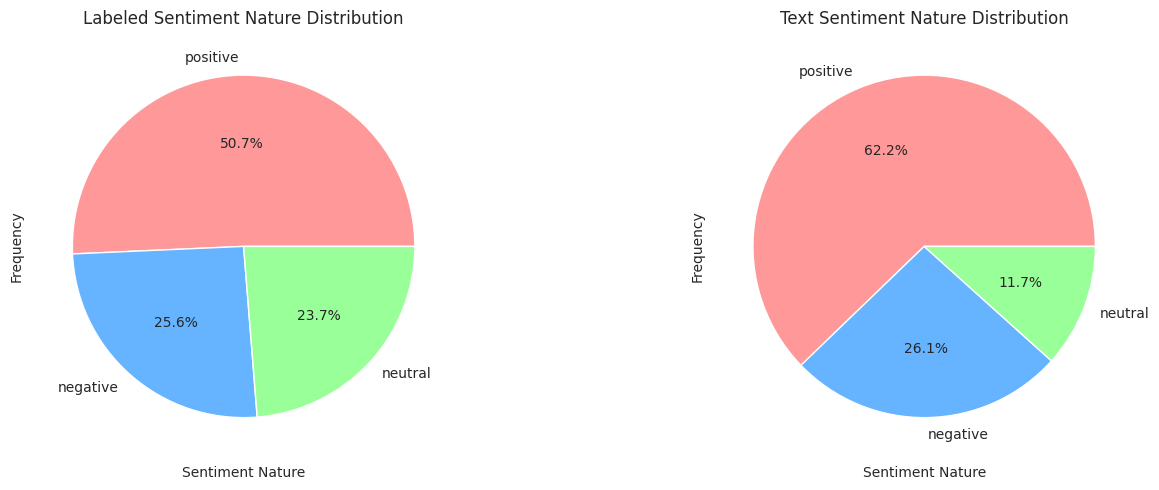

In [ ]:
import os
# compare component of sentiment nature based on texts and labeled sentiments side by side
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# draw pie chart for labeled sentiment nature
df1['Sentiment_Nature'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0], colors=['#ff9999', '#66b3ff', '#99ff99'])
ax[0].set_xlabel('Sentiment Nature')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Labeled Sentiment Nature Distribution')
df1['Text_Sentiment_Nature'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[1], colors=['#ff9999', '#66b3ff', '#99ff99'])
ax[1].set_xlabel('Sentiment Nature')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Text Sentiment Nature Distribution')
plt.tight_layout()
output_dir = '/content/drive/MyDrive'
plt.savefig(os.path.join(output_dir, 'sentiment_nature_distribution_Label_vs_Text.png'))
plt.show()


According to the major sentiment distribution, more posts have positive texts but are labeled as negative or neutral.

What are the major sentiments within positive, neutral, and negative?

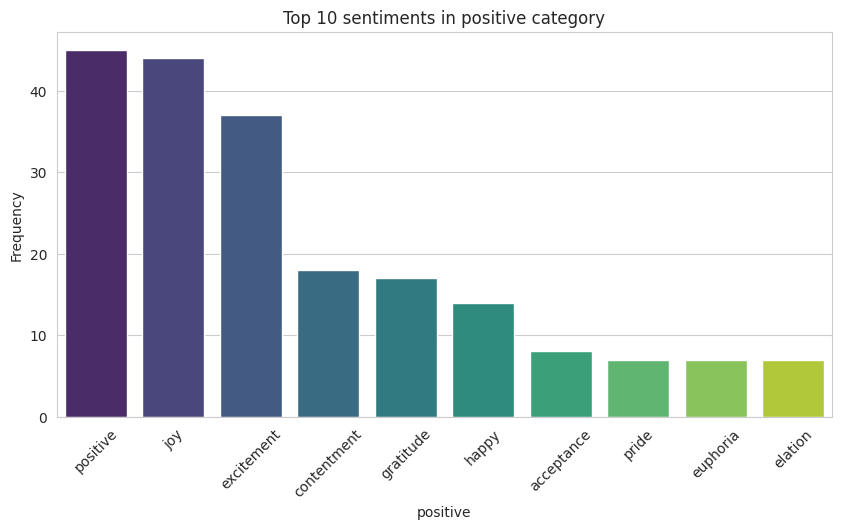

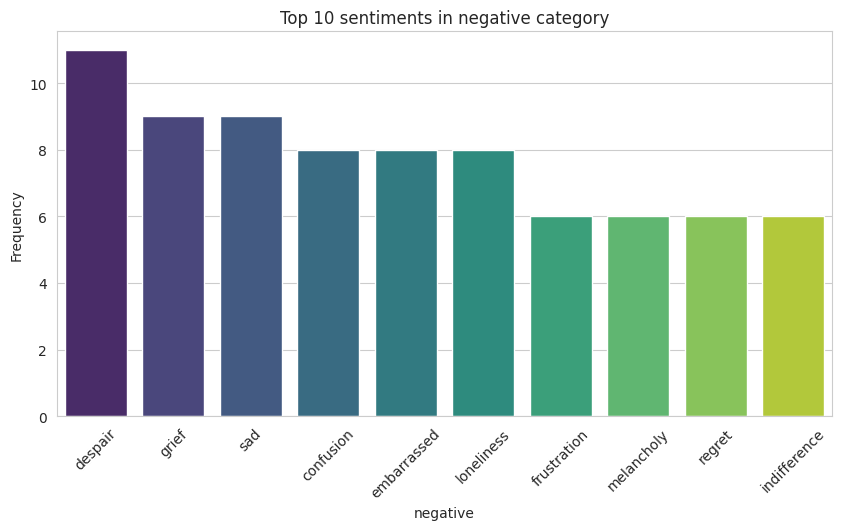

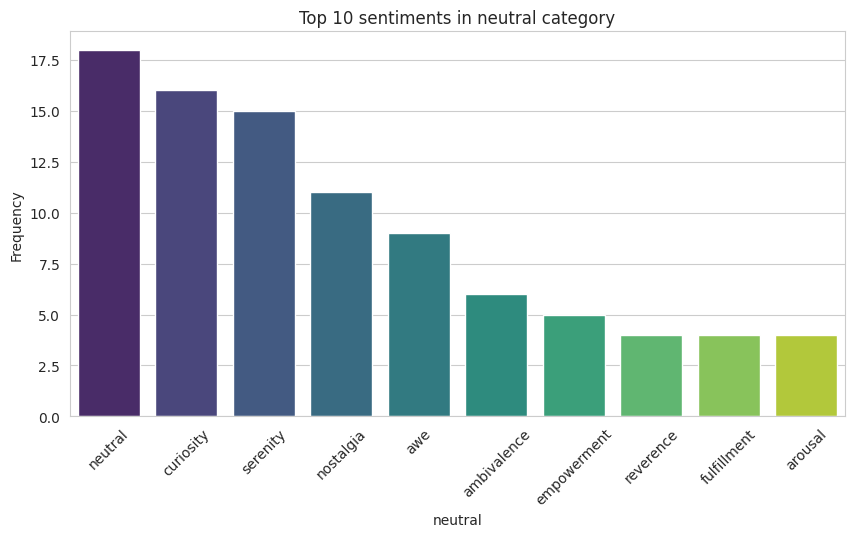

In [ ]:
# visualize the major sentiment composition in each category of the sentiment nature
for nature in df1['Sentiment_Nature'].unique():
    plt.figure(figsize=(10,5))
    sns.countplot(x='Sentiment', data=df1[df1['Sentiment_Nature'] == nature], order=df1[df1['Sentiment_Nature'] == nature]['Sentiment'].value_counts().index[:10], palette='viridis')
    plt.xticks(rotation=45)
    plt.xlabel(nature)
    plt.ylabel('Frequency')
    plt.title(f'Top 10 sentiments in {nature} category')
    plt.savefig(f'/content/drive/MyDrive/top_ten_sentiments_in_{nature}.png')
    plt.show()


Based on these three pie charts, most sentiments categorized in 'positive' and 'negative' are resonable, but some sentiments listed in 'neutral' is are questionable. <br><br>Ex. 'awe', 'empowerment', and 'enchantment' should be labeled 'positive', <br>whereas 'desolation' and 'nostalgia' should be labeled 'negative'.

Now we want to explore what are some common words within each sentiment nature, and see it the most frequent words would align with the sentiments listed above.

### Common Words within Sentiment Groups

In [ ]:
# create a column to store word list of tokenized clean texts
df1['Temp_List'] = df1['Cleaned_Text'].apply(lambda x: str(x).split())

In [ ]:
# list out the top 10 most common positive words in the text
top = Counter([item for sublist in df1[df1['Sentiment'] == 'positive']['Temp_List'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Reds')

,Common_words,count
0,new,10
1,day,4
2,weekend,4
3,feeling,4
4,enjoying,3
5,💪,3
6,exploring,3
7,reflecting,3
8,friends,3
9,good,3


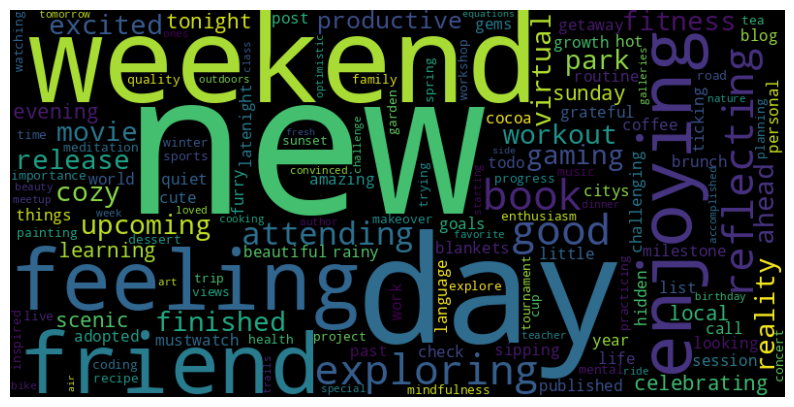

In [ ]:
words = ' '.join([item for sublist in df1[df1['Sentiment'] == 'positive']['Temp_List'] for item in sublist])
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('/content/drive/MyDrive/wordcloud_positive.png')
plt.show()


In [ ]:
# list out the top 10 most common neutral words in the text
top = Counter([item for sublist in df1[df1['Sentiment'] == 'neutral']['Temp_List'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_neutral.style.background_gradient(cmap='Greens')

,Common_words,count
0,new,6
1,school,5
2,attending,4
3,exploring,3
4,club,3
5,trying,2
6,recipe,2
7,upcoming,2
8,community,2
9,event,2


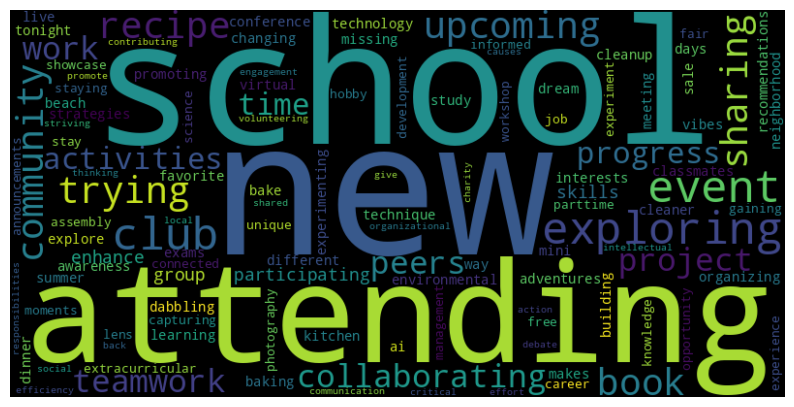

In [ ]:
words = ' '.join([item for sublist in df1[df1['Sentiment'] == 'neutral']['Temp_List'] for item in sublist])
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('/content/drive/MyDrive/wordcloud_neutral.png')
plt.show()


In [ ]:
# list out the top 10 most common negative words in the text
top = Counter([item for sublist in df1[df1['Sentiment'] == 'negative']['Temp_List'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_negative.style.background_gradient(cmap='Blues')

,Common_words,count
0,feeling,2
1,traffic,1
2,terrible,1
3,morning,1
4,political,1
5,discussions,1
6,heating,1
7,timeline,1
8,bit,1
9,weather,1


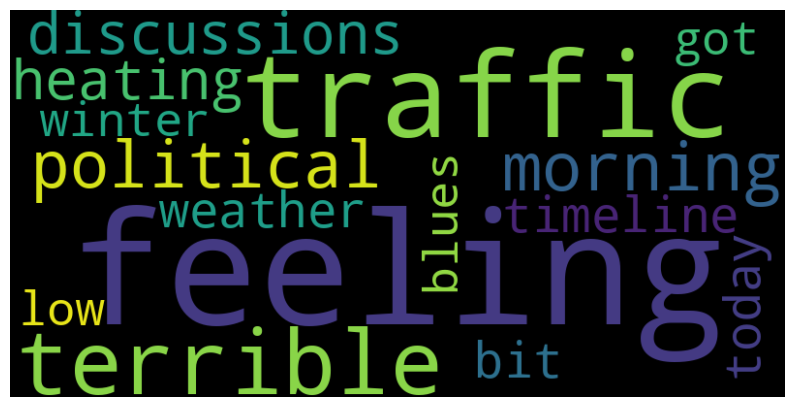

In [ ]:
words = ' '.join([item for sublist in df1[df1['Sentiment'] == 'negative']['Temp_List'] for item in sublist])
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('/content/drive/MyDrive/wordcloud_negative.png')
plt.show()


## Text Sentiment Classification Analysis

Now we want to explore whether our original texts are labeled with appropriate sentiments, which requires higher granularity then assigning nature of sentiment via polarity score.
We want to conduct a **multi-class classfication** and see how many records are classified with appropriate labels.

### Data Preparation

In [ ]:
df2 = df1.copy()
df2.head()

,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour,Day_of_Week,Sentiment_Score,Sentiment_Nature,Cleaned_Text,Text_Sentiment_Score,Text_Sentiment_Nature,Temp_List
id,,,,,,,,,,,,,,,,,,,,
0,Enjoying a beautiful day at the park! ...,positive,2023-01-15 12:30:00,User123,twitter,#Nature #Park,15.0,30.0,usa,2023,January,15,12,Sunday,0.5574,positive,enjoying beautiful day park!,0.8221,positive,"[enjoying, beautiful, day, park!]"
1,Traffic was terrible this morning. ...,negative,2023-01-15 08:45:00,CommuterX,twitter,#Traffic #Morning,5.0,10.0,canada,2023,January,15,8,Sunday,-0.5719,negative,traffic terrible morning,-0.4767,negative,"[traffic, terrible, morning]"
2,Just finished an amazing workout! 💪 ...,positive,2023-01-15 15:45:00,FitnessFan,instagram,#Fitness #Workout,20.0,40.0,usa,2023,January,15,15,Sunday,0.5574,positive,finished amazing workout! 💪,0.6239,positive,"[finished, amazing, workout!, 💪]"
3,Excited about the upcoming weekend getaway! ...,positive,2023-01-15 18:20:00,AdventureX,facebook,#Travel #Adventure,8.0,15.0,uk,2023,January,15,18,Sunday,0.5574,positive,excited upcoming weekend getaway!,0.4003,positive,"[excited, upcoming, weekend, getaway!]"
4,Trying out a new recipe for dinner tonight. ...,neutral,2023-01-15 19:55:00,ChefCook,instagram,#Cooking #Food,12.0,25.0,australia,2023,January,15,19,Sunday,0.0000,neutral,trying new recipe dinner tonight,0.0000,neutral,"[trying, new, recipe, dinner, tonight]"


In [ ]:
df2['Sentiment'].value_counts()

,count
Sentiment,
positive,45
joy,44
excitement,37
contentment,18
neutral,18
gratitude,17
curiosity,16
serenity,15
happy,14


There too many sentiments to classify in our dataset, and many sentiments only occur once in total -  making it harder for the model to learn distinct patterns between classes

In [ ]:
# trim the text dataset to only include the sentiments thta have at least 5 occurrences
df2 = df2.groupby('Sentiment').filter(lambda x: len(x) >= 5)
df2['Sentiment'].value_counts()

,count
Sentiment,
positive,45
joy,44
excitement,37
contentment,18
neutral,18
gratitude,17
curiosity,16
serenity,15
happy,14


In [ ]:
df2.shape

(441, 20)

In [ ]:
X = df2['Cleaned_Text']
y = df2['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=52)

In [ ]:
# word embedding usinf TfidfVectorizer
# create a TfidfVectorizer object
tfidf = TfidfVectorizer()
# fit and transform the training data
X_train_tfidf = tfidf.fit_transform(X_train)
# transform the test data
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
X_train_tfidf.shape, X_test_tfidf.shape

((352, 1494), (89, 1494))

## Baseline model: KNN & SVM & SGDC

KNN is the most intuitive approach for tackling multi-class classification tasks by leveraging the similarity of data points in the feature space.<br>
Linear SVC: SVM is a binary classification, but its Linear Support Vector Classification can be used for one vs rest classification.<br>
SGDC Classifier: A linear classifiers (SVM, logistic regression, etc.) with SGD training.

In [ ]:
# create a KNeighborsClassifier object
knn = KNeighborsClassifier()
# fit the model
knn.fit(X_train_tfidf, y_train)
# predict the test data
y_pred = knn.predict(X_test_tfidf)

In [ ]:
# print the accuracy score and classification report
print("KNN Results:")
print(f"Accuracy: {round(knn.score(X_test_tfidf, y_test),4)}")
print('classification report for test data:')
print("Classification Report:\n", classification_report(y_test, y_pred))

KNN Results:
Accuracy: 0.3933
classification report for test data:
Classification Report:
                precision    recall  f1-score   support

   acceptance       0.00      0.00      0.00         0
  ambivalence       0.50      1.00      0.67         1
          awe       0.00      0.00      0.00         0
          bad       0.50      0.50      0.50         2
     betrayal       0.00      0.00      0.00         0
   bitterness       0.50      0.50      0.50         2
    confusion       0.50      1.00      0.67         2
  contentment       0.25      0.25      0.25         4
    curiosity       0.50      0.67      0.57         3
      despair       0.67      1.00      0.80         4
determination       0.50      1.00      0.67         1
      disgust       1.00      0.50      0.67         2
      elation       0.00      0.00      0.00         0
  embarrassed       0.00      0.00      0.00         1
  empowerment       0.00      0.00      0.00         1
   enthusiasm       0.33    

SVM can be used for multi-class classification. While SVM is fundamentally a binary classifier, it can be extended for multi-class classification using strategies such as One-vs-One: This involves training a separate classifier for every pair of classes

In [ ]:
# create a SVC object
svm_classifier = LinearSVC(random_state=42)
svm_classifier.fit(X_train_tfidf, y_train)
# predict the test data
y_pred = svm_classifier.predict(X_test_tfidf)

In [ ]:
print("Support Vector Machine Results:")
print(f"Accuracy: {round(svm_classifier.score(X_test_tfidf, y_test),4)}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Support Vector Machine Results:
Accuracy: 0.573
Classification Report:
                precision    recall  f1-score   support

   acceptance       0.00      0.00      0.00         0
  ambivalence       1.00      1.00      1.00         1
          bad       1.00      0.50      0.67         2
     betrayal       0.00      0.00      0.00         0
   bitterness       1.00      0.50      0.67         2
    confusion       0.67      1.00      0.80         2
  contentment       1.00      0.25      0.40         4
    curiosity       0.67      0.67      0.67         3
      despair       1.00      1.00      1.00         4
determination       1.00      1.00      1.00         1
      disgust       1.00      1.00      1.00         2
  embarrassed       0.00      0.00      0.00         1
  empowerment       0.00      0.00      0.00         1
   enthusiasm       1.00      0.50      0.67         2
     euphoria       1.00      1.00      1.00         1
   excitement       0.33      0.40      0.36   

In [ ]:
# create a SGDC object
sgdc = SGDClassifier()
# fit the model
sgdc.fit(X_train_tfidf, y_train)
# predict the test data
y_pred = sgdc.predict(X_test_tfidf)

In [ ]:
print("SGDC Classification Results:")
print(f"Accuracy: {round(sgdc.score(X_test_tfidf, y_test),4)}")
print("Classification Report:\n", classification_report(y_test, y_pred))

SGDC Classification Results:
Accuracy: 0.573
Classification Report:
                precision    recall  f1-score   support

  ambivalence       1.00      1.00      1.00         1
          bad       0.50      0.50      0.50         2
     betrayal       0.00      0.00      0.00         0
   bitterness       1.00      0.50      0.67         2
    confusion       1.00      1.00      1.00         2
  contentment       0.25      0.25      0.25         4
    curiosity       1.00      0.67      0.80         3
      despair       0.80      1.00      0.89         4
determination       0.50      1.00      0.67         1
      disgust       1.00      1.00      1.00         2
      elation       0.00      0.00      0.00         0
  embarrassed       0.00      0.00      0.00         1
  empowerment       1.00      1.00      1.00         1
   enthusiasm       0.50      0.50      0.50         2
     euphoria       1.00      1.00      1.00         1
   excitement       0.67      0.40      0.50      

**The accuracy of our baseline classification model is sub-optimal, NLP Deep Learning is required.**

## NLP Text-Sentiment Analysis using distilBERT

In my previous approach, I have used LSTM model to train for sentiment classification, but the issue of overfitting persists - this is due to the small amount of data given in this dataset.<br>
BERT is a pre-trained model for text classfication,and it outperforms LSTM o due to its ability to leverage large amounts of data and its bidirectional context.<br>
So in this case, I will utilize the distilBERT model mentioned in other kaggle notebook using the same dataset.
Reference to Kaggle Notebook [Social Media Sentiments Analysis using distilbert](http://www.kaggle.com/code/mukaffimoin/social-media-sentiments-analysis-using-distilbert)

### Data Selection

In [ ]:
df4 = df1.copy()
top_sentiments = df4['Sentiment'].value_counts()[df4['Sentiment'].value_counts() >= 5].index
# df4 = df4[df4['Sentiment'].isin(top_10_sentiment)]
df4.loc[~df4['Sentiment'].isin(top_sentiments), 'Sentiment'] = 'miscellaneous'
df4['Sentiment'].value_counts()

,count
Sentiment,
miscellaneous,271
positive,45
joy,44
excitement,37
contentment,18
neutral,18
gratitude,17
curiosity,16
serenity,15


In [ ]:
# label encoding all selected sentiments
le = LabelEncoder()
df4['Sentiment'] = le.fit_transform(df4['Sentiment'])
df4['Sentiment'].value_counts().shape

(42,)

### Text Tokenization

In [ ]:
# load pre-trained model & tokenizer
PRE_TRAINED_MODEL_NAME = 'distilbert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [ ]:
# use sample text for tokenization
sample_txt = 'Enjoying a beautiful day at the park!'

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Enjoying a beautiful day at the park!
   Tokens: ['enjoying', 'a', 'beautiful', 'day', 'at', 'the', 'park', '!']
Token IDs: [9107, 1037, 3376, 2154, 2012, 1996, 2380, 999]


In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  truncation=True,
  return_tensors='pt',  # Return PyTorch tensors

)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
token_lens = []

for txt in df4.Cleaned_Text:
  #tokenizing the text
      tokens = tokenizer.encode(txt, max_length=512)
      token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

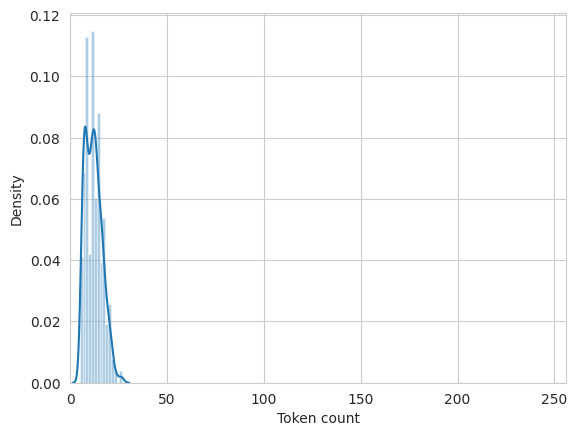

In [ ]:
# visualize token counts
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

In [ ]:
selected_columns = ['Cleaned_Text', 'Sentiment']
df4 = df4[selected_columns]
df4.head()

,Cleaned_Text,Sentiment
id,,
0,enjoying beautiful day park!,36
1,traffic terrible morning,32
2,finished amazing workout! 💪,36
3,excited upcoming weekend getaway!,36
4,trying new recipe dinner tonight,33


In [ ]:
# set up fixed length for each inputs
MAX_LEN = 50

### Data Preparation for PyTorch

In [ ]:
# preprocess current df to dataset in pytorch
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    # Tokenization: The tokenizer.encode_plus method ensures the text is converted into a format suitable for transformer models.
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
    # Padding and Truncation: Handles variable-length sequences by padding or truncating to a fixed length
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    # Returns data as PyTorch tensors
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
# split data again for training, evaluation, testing
df4_train, df4_test = train_test_split(df4, test_size=0.30, shuffle=True)
df4_val, df4_test = train_test_split(df4_test, test_size=0.50,shuffle=True)

In [ ]:
# batch the preprocessed torch dataset and prepare it for model training
def create_data_loader(df4, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df4.Cleaned_Text.to_numpy(),
    targets=df4.Sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len,

  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4,
    shuffle=True
  )

In [ ]:
df4_train.shape, df4_val.shape, df4_test.shape

((498, 2), (107, 2), (107, 2))

In [ ]:
BATCH_SIZE = 8
# convert df to dataset(tensor) for pytorch
train_data_loader = create_data_loader(df4_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df4_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df4_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([8, 50])
torch.Size([8, 50])
torch.Size([8])


### Model Building

In [ ]:
# import pre-trained model from bert
bert_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
last_hidden_state = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [ ]:
PRE_TRAINED_MODEL_NAME

'distilbert-base-uncased'

In [ ]:
bert_model.config.hidden_size

768

In [ ]:
# Build a sentiment classfier on BERT by orchestrating DL layers & defining output
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)  # model
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )

        # Assuming logits are in the first element of the tuple
        logits = outputs[0]

        # Apply dropout and linear layer
        output = self.drop(logits)

        # Assuming you want to use the representation for the [CLS] token
        cls_representation = logits[:, 0, :]

        return self.out(cls_representation)

In [ ]:
# can use cpu since it is a small dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
# instantite a sentiment classifier model
model = SentimentClassifier(42)
model = model.to(device)

In [ ]:
model

In [ ]:
# load input & attention_mask
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 50])
torch.Size([8, 50])


In [ ]:
# use softmax for output simulation(no representation)
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.0183, 0.0242, 0.0220, 0.0216, 0.0282, 0.0151, 0.0170, 0.0255, 0.0194,
         0.0295, 0.0214, 0.0214, 0.0315, 0.0145, 0.0337, 0.0262, 0.0168, 0.0211,
         0.0324, 0.0185, 0.0296, 0.0343, 0.0207, 0.0218, 0.0162, 0.0274, 0.0171,
         0.0261, 0.0195, 0.0243, 0.0260, 0.0266, 0.0191, 0.0263, 0.0318, 0.0193,
         0.0263, 0.0264, 0.0185, 0.0370, 0.0244, 0.0228],
        [0.0178, 0.0262, 0.0207, 0.0221, 0.0281, 0.0162, 0.0175, 0.0262, 0.0205,
         0.0304, 0.0207, 0.0237, 0.0346, 0.0167, 0.0349, 0.0266, 0.0192, 0.0211,
         0.0260, 0.0173, 0.0323, 0.0359, 0.0220, 0.0201, 0.0155, 0.0298, 0.0188,
         0.0227, 0.0203, 0.0242, 0.0230, 0.0265, 0.0180, 0.0267, 0.0267, 0.0208,
         0.0261, 0.0267, 0.0182, 0.0353, 0.0212, 0.0226],
        [0.0166, 0.0249, 0.0209, 0.0232, 0.0288, 0.0170, 0.0169, 0.0276, 0.0213,
         0.0280, 0.0214, 0.0225, 0.0328, 0.0159, 0.0337, 0.0265, 0.0177, 0.0187,
         0.0279, 0.0177, 0.0334, 0.0306, 0.0206, 0.0209, 0.0147, 0.0245, 0

### Model Training

In [ ]:
# set up hyperparameter for training
EPOCHS = 20

optimizer = AdamW(model.parameters(), lr=2e-5, )
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=4,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device) # use crossrntropy for text classification

In [ ]:
# define training model
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()

    losses = []
    correct_predictions = 0

    # tqdm for progress monitoring (visualization)
    data_loader = tqdm(data_loader, desc="Training", unit="batch")

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].squeeze().to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # Update tqdm description with the current loss
        data_loader.set_postfix(loss=np.mean(losses))

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
# define evaluation model
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0


    data_loader = tqdm(data_loader, desc="Evaluating", unit="batch")

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            # Ensure targets are of type long
            targets = targets.view(-1)  # Reshape to a 1-dimensional tensor if needed
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

            # Update tqdm description with the current loss
            data_loader.set_postfix(loss=np.mean(losses))

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df4_train)
  )

  print(f'\nTrain loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df4_val)
  )

  print(f'\nVal   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  # if val_acc > best_accuracy:
  #   torch.save(model.state_dict(), 'best_model_state.bin')
  #   best_accuracy = val_acc

Epoch 1/20
----------


Training: 100%|██████████| 63/63 [03:05<00:00,  2.95s/batch, loss=3.02]



Train loss 3.0170481867260404 accuracy 0.3273092369477912


Evaluating: 100%|██████████| 14/14 [00:09<00:00,  1.48batch/s, loss=2.8]



Val   loss 2.8030851738793507 accuracy 0.3925233644859813

Epoch 2/20
----------


Training: 100%|██████████| 63/63 [02:53<00:00,  2.75s/batch, loss=2.45]



Train loss 2.446420173796396 accuracy 0.42168674698795183


Evaluating: 100%|██████████| 14/14 [00:08<00:00,  1.61batch/s, loss=2.5]



Val   loss 2.4992945109094893 accuracy 0.411214953271028

Epoch 3/20
----------


Training: 100%|██████████| 63/63 [02:51<00:00,  2.73s/batch, loss=1.88]



Train loss 1.8816831972863939 accuracy 0.5080321285140562


Evaluating: 100%|██████████| 14/14 [00:08<00:00,  1.65batch/s, loss=2.22]



Val   loss 2.220544857638223 accuracy 0.45794392523364486

Epoch 4/20
----------


Training: 100%|██████████| 63/63 [02:57<00:00,  2.81s/batch, loss=1.36]



Train loss 1.362082619988729 accuracy 0.6646586345381527


Evaluating: 100%|██████████| 14/14 [00:08<00:00,  1.66batch/s, loss=2.1]



Val   loss 2.103212296962738 accuracy 0.4766355140186916

Epoch 5/20
----------


Training: 100%|██████████| 63/63 [02:51<00:00,  2.73s/batch, loss=0.906]



Train loss 0.9062193225300501 accuracy 0.8493975903614458


Evaluating: 100%|██████████| 14/14 [00:08<00:00,  1.61batch/s, loss=1.76]



Val   loss 1.7614793649741582 accuracy 0.5981308411214953

Epoch 6/20
----------


Training: 100%|██████████| 63/63 [02:51<00:00,  2.72s/batch, loss=0.62]



Train loss 0.6202637594607141 accuracy 0.9417670682730924


Evaluating: 100%|██████████| 14/14 [00:10<00:00,  1.28batch/s, loss=1.71]



Val   loss 1.7085088193416595 accuracy 0.5981308411214953

Epoch 7/20
----------


Training: 100%|██████████| 63/63 [02:55<00:00,  2.79s/batch, loss=0.44]



Train loss 0.4403814590639538 accuracy 0.963855421686747


Evaluating: 100%|██████████| 14/14 [00:09<00:00,  1.43batch/s, loss=1.64]



Val   loss 1.6363528328282493 accuracy 0.5981308411214953

Epoch 8/20
----------


Training: 100%|██████████| 63/63 [02:50<00:00,  2.71s/batch, loss=0.319]



Train loss 0.3191971447732713 accuracy 0.9899598393574297


Evaluating: 100%|██████████| 14/14 [00:09<00:00,  1.42batch/s, loss=1.63]



Val   loss 1.6258959003857203 accuracy 0.616822429906542

Epoch 9/20
----------


Training: 100%|██████████| 63/63 [02:51<00:00,  2.72s/batch, loss=0.248]



Train loss 0.24794715016134203 accuracy 0.9959839357429718


Evaluating: 100%|██████████| 14/14 [00:09<00:00,  1.43batch/s, loss=1.48]



Val   loss 1.4833484079156602 accuracy 0.6355140186915887

Epoch 10/20
----------


Training: 100%|██████████| 63/63 [02:52<00:00,  2.74s/batch, loss=0.197]



Train loss 0.19650088244723896 accuracy 0.9979919678714859


Evaluating: 100%|██████████| 14/14 [00:09<00:00,  1.43batch/s, loss=1.62]



Val   loss 1.6189511375767844 accuracy 0.6448598130841121

Epoch 11/20
----------


Training: 100%|██████████| 63/63 [02:52<00:00,  2.74s/batch, loss=0.163]



Train loss 0.16267268253224237 accuracy 0.9959839357429718


Evaluating: 100%|██████████| 14/14 [00:09<00:00,  1.55batch/s, loss=1.56]



Val   loss 1.5611173148666109 accuracy 0.6448598130841121

Epoch 12/20
----------


Training: 100%|██████████| 63/63 [02:52<00:00,  2.73s/batch, loss=0.135]



Train loss 0.13497408899286437 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:08<00:00,  1.60batch/s, loss=1.48]



Val   loss 1.484618173113891 accuracy 0.6355140186915887

Epoch 13/20
----------


Training: 100%|██████████| 63/63 [02:52<00:00,  2.74s/batch, loss=0.127]



Train loss 0.12695195389881966 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:08<00:00,  1.67batch/s, loss=1.46]



Val   loss 1.4558258514319147 accuracy 0.6635514018691588

Epoch 14/20
----------


Training: 100%|██████████| 63/63 [02:52<00:00,  2.74s/batch, loss=0.107]



Train loss 0.10727751349645948 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:08<00:00,  1.66batch/s, loss=1.58]



Val   loss 1.5818609786885125 accuracy 0.6635514018691588

Epoch 15/20
----------


Training: 100%|██████████| 63/63 [02:54<00:00,  2.76s/batch, loss=0.0946]



Train loss 0.09458248181239007 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:09<00:00,  1.44batch/s, loss=1.64]



Val   loss 1.640748815877097 accuracy 0.6635514018691588

Epoch 16/20
----------


Training: 100%|██████████| 63/63 [02:49<00:00,  2.70s/batch, loss=0.0903]



Train loss 0.09032527679607036 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:09<00:00,  1.47batch/s, loss=1.49]



Val   loss 1.4870097147566932 accuracy 0.6728971962616822

Epoch 17/20
----------


Training: 100%|██████████| 63/63 [02:49<00:00,  2.70s/batch, loss=0.0877]



Train loss 0.08773217601553789 accuracy 0.9979919678714859


Evaluating: 100%|██████████| 14/14 [00:09<00:00,  1.48batch/s, loss=1.47]



Val   loss 1.472692813192095 accuracy 0.6635514018691588

Epoch 18/20
----------


Training: 100%|██████████| 63/63 [02:51<00:00,  2.73s/batch, loss=0.0796]



Train loss 0.0795785379669969 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:09<00:00,  1.41batch/s, loss=1.53]



Val   loss 1.5291028150490351 accuracy 0.6635514018691588

Epoch 19/20
----------


Training: 100%|██████████| 63/63 [02:54<00:00,  2.76s/batch, loss=0.0773]



Train loss 0.07734206298159228 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:10<00:00,  1.38batch/s, loss=1.62]



Val   loss 1.624372933592115 accuracy 0.6635514018691588

Epoch 20/20
----------


Training: 100%|██████████| 63/63 [02:56<00:00,  2.80s/batch, loss=0.0753]



Train loss 0.07532558832613248 accuracy 1.0


Evaluating: 100%|██████████| 14/14 [00:08<00:00,  1.65batch/s, loss=1.53]


Val   loss 1.5300382226705551 accuracy 0.6635514018691588

CPU times: user 54min 57s, sys: 4min 59s, total: 59min 57s
Wall time: 1h 53s


After 10 epoches, it is evident that as the training accuracy reaches 1.0, the accuracy of evaluation cannot go over 0.71. This is better than our baseline model, but it still has a problem of **overfitting**.

### Evaluate Model

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df4_test)
)

test_acc.item()

Evaluating: 100%|██████████| 14/14 [00:08<00:00,  1.62batch/s, loss=1.48]


0.6728971962616822

In conclusion, we use basic multi-class cassfication model KNN, Linear SVM to classify the given text and align with labeled sentiments with an accuracy of 0.6, but we can also use pre-trained model like BERT to optimize the result with an accuracy of 0.72.

## Sentiment Trend Analysis

In [ ]:
df3 = df1.copy()
df3.head()

,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour,Day_of_Week,Sentiment_Score,Sentiment_Nature,Cleaned_Text,Text_Sentiment_Score,Text_Sentiment_Nature,Temp_List
id,,,,,,,,,,,,,,,,,,,,
0,Enjoying a beautiful day at the park! ...,positive,2023-01-15 12:30:00,User123,twitter,#Nature #Park,15.0,30.0,usa,2023,January,15,12,Sunday,0.5574,positive,enjoying beautiful day park!,0.8221,positive,"[enjoying, beautiful, day, park!]"
1,Traffic was terrible this morning. ...,negative,2023-01-15 08:45:00,CommuterX,twitter,#Traffic #Morning,5.0,10.0,canada,2023,January,15,8,Sunday,-0.5719,negative,traffic terrible morning,-0.4767,negative,"[traffic, terrible, morning]"
2,Just finished an amazing workout! 💪 ...,positive,2023-01-15 15:45:00,FitnessFan,instagram,#Fitness #Workout,20.0,40.0,usa,2023,January,15,15,Sunday,0.5574,positive,finished amazing workout! 💪,0.6239,positive,"[finished, amazing, workout!, 💪]"
3,Excited about the upcoming weekend getaway! ...,positive,2023-01-15 18:20:00,AdventureX,facebook,#Travel #Adventure,8.0,15.0,uk,2023,January,15,18,Sunday,0.5574,positive,excited upcoming weekend getaway!,0.4003,positive,"[excited, upcoming, weekend, getaway!]"
4,Trying out a new recipe for dinner tonight. ...,neutral,2023-01-15 19:55:00,ChefCook,instagram,#Cooking #Food,12.0,25.0,australia,2023,January,15,19,Sunday,0.0000,neutral,trying new recipe dinner tonight,0.0000,neutral,"[trying, new, recipe, dinner, tonight]"


In [ ]:
df3['Year'].value_counts()

,count
Year,
2023,287
2019,70
2020,64
2022,60
2021,59
2018,54
2017,42
2016,38
2015,19


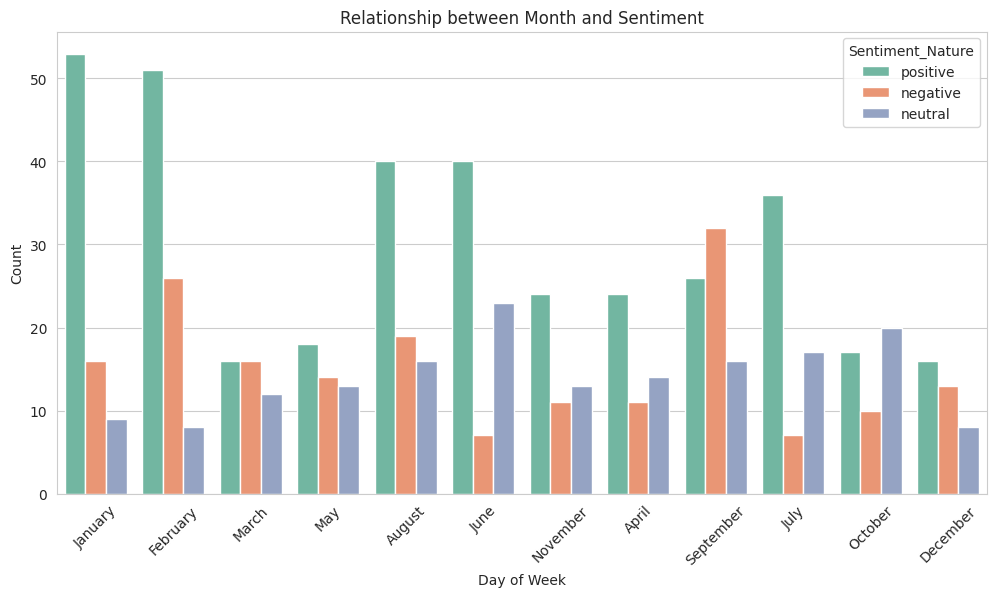

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Month', hue='Sentiment_Nature', data=df3, palette='Set2')
plt.title('Relationship between Month and Sentiment')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.savefig('/content/drive/MyDrive/month_sentiment.png')
plt.show()


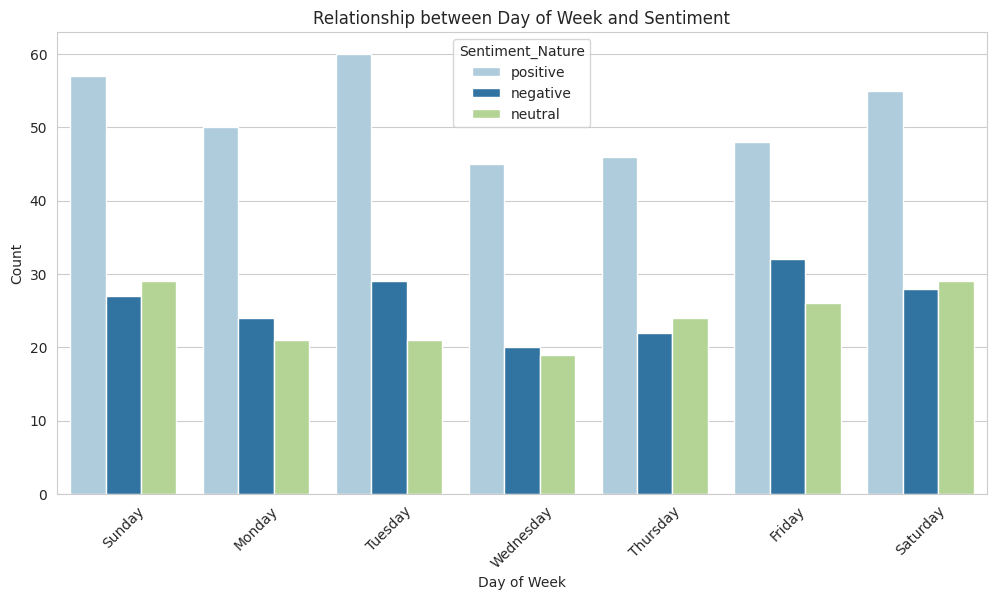

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Day_of_Week', hue='Sentiment_Nature', data=df3, palette='Paired')
plt.title('Relationship between Day of Week and Sentiment')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.savefig('/content/drive/MyDrive/day_of_week_sentiment.png')
plt.show()


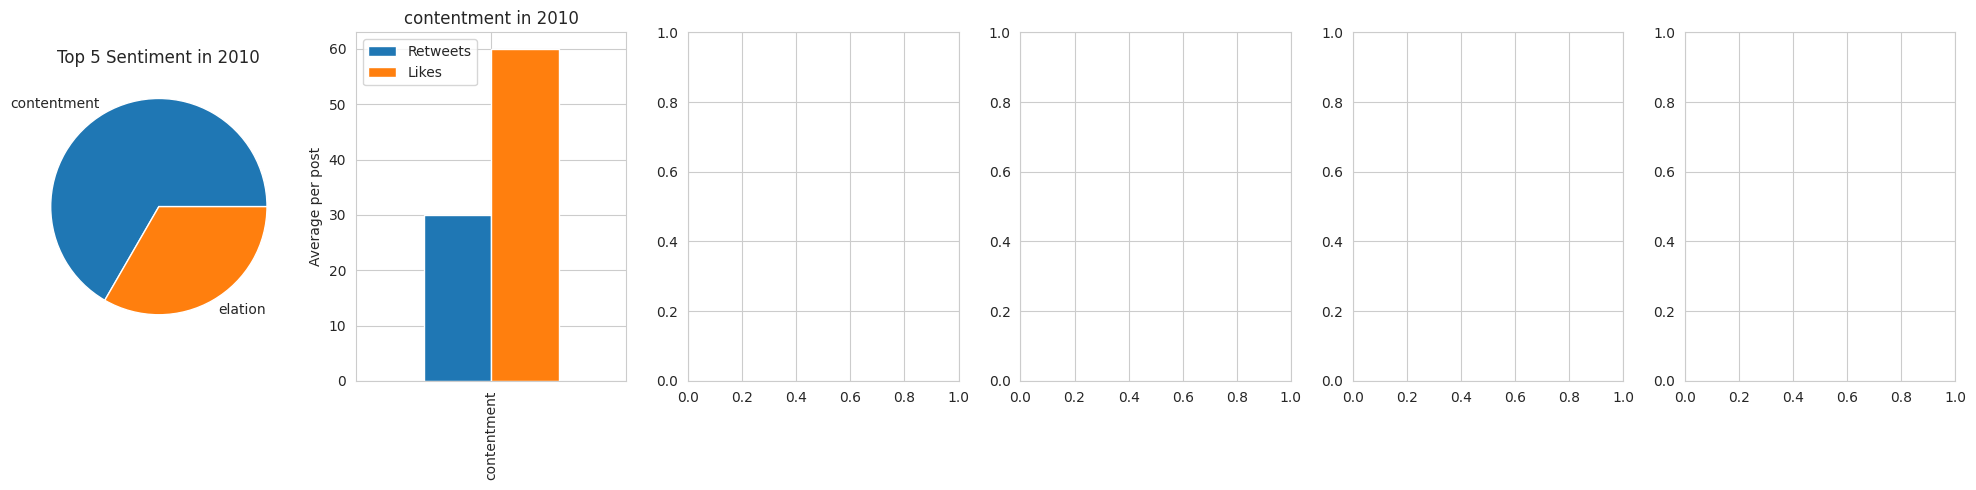

<Figure size 640x480 with 0 Axes>

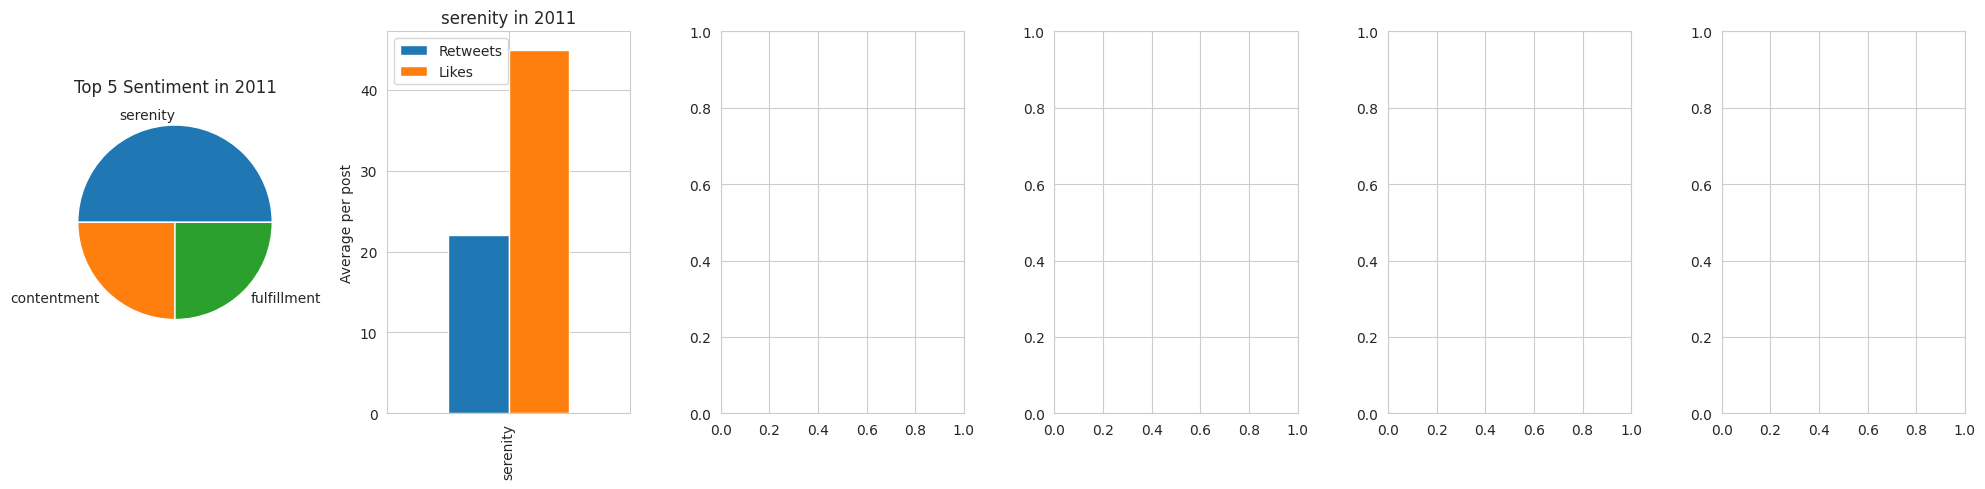

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

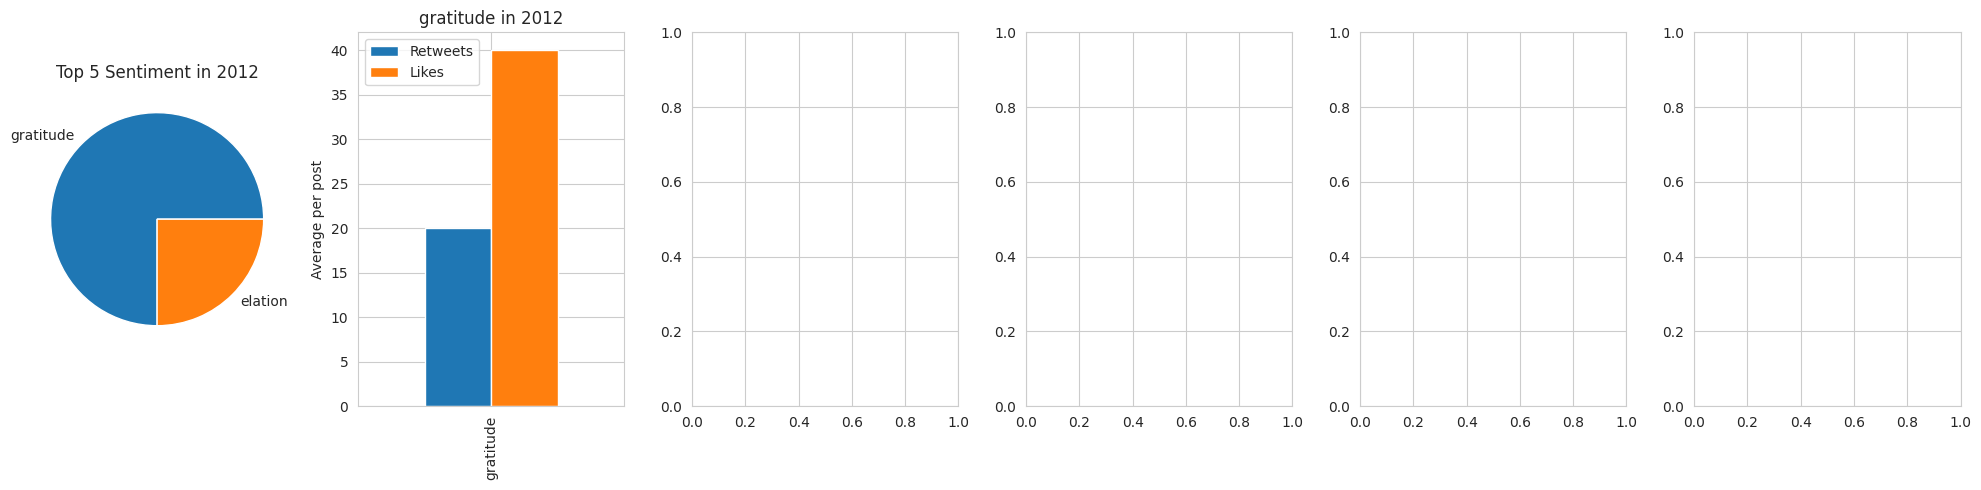

<Figure size 640x480 with 0 Axes>

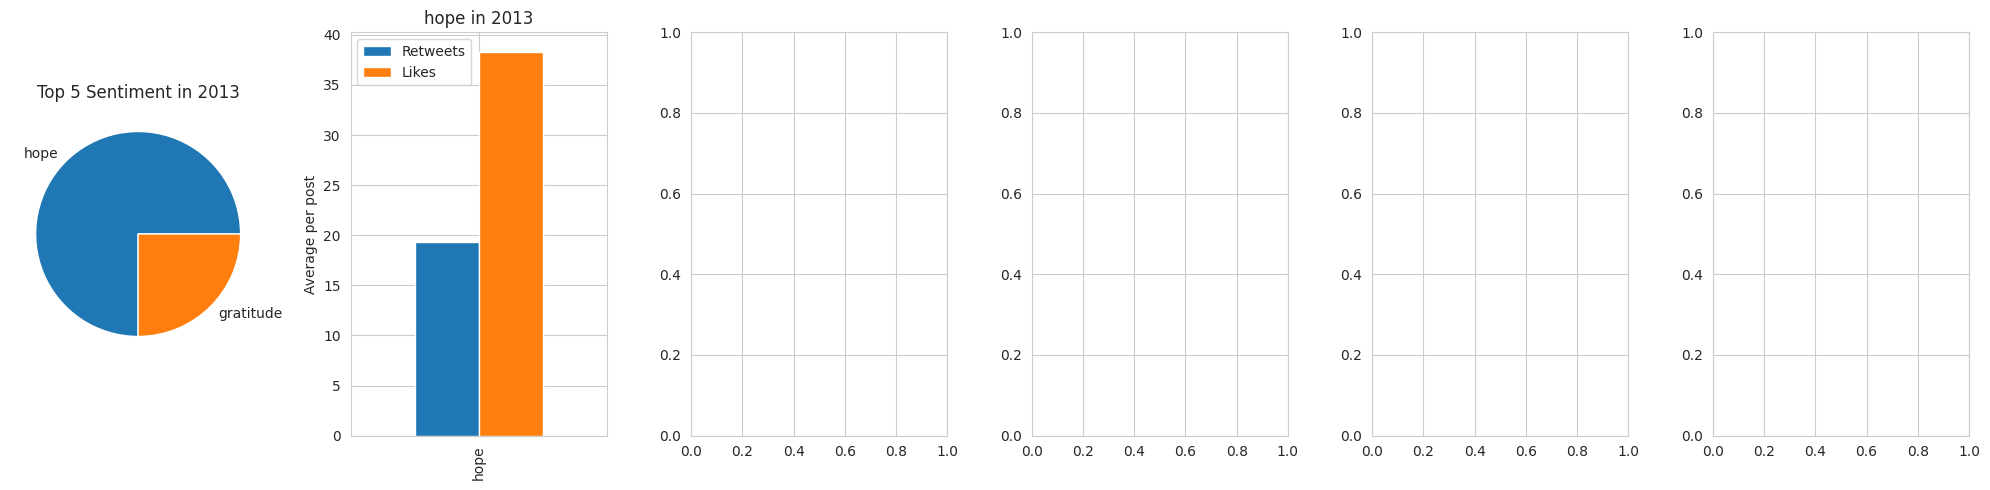

<Figure size 640x480 with 0 Axes>

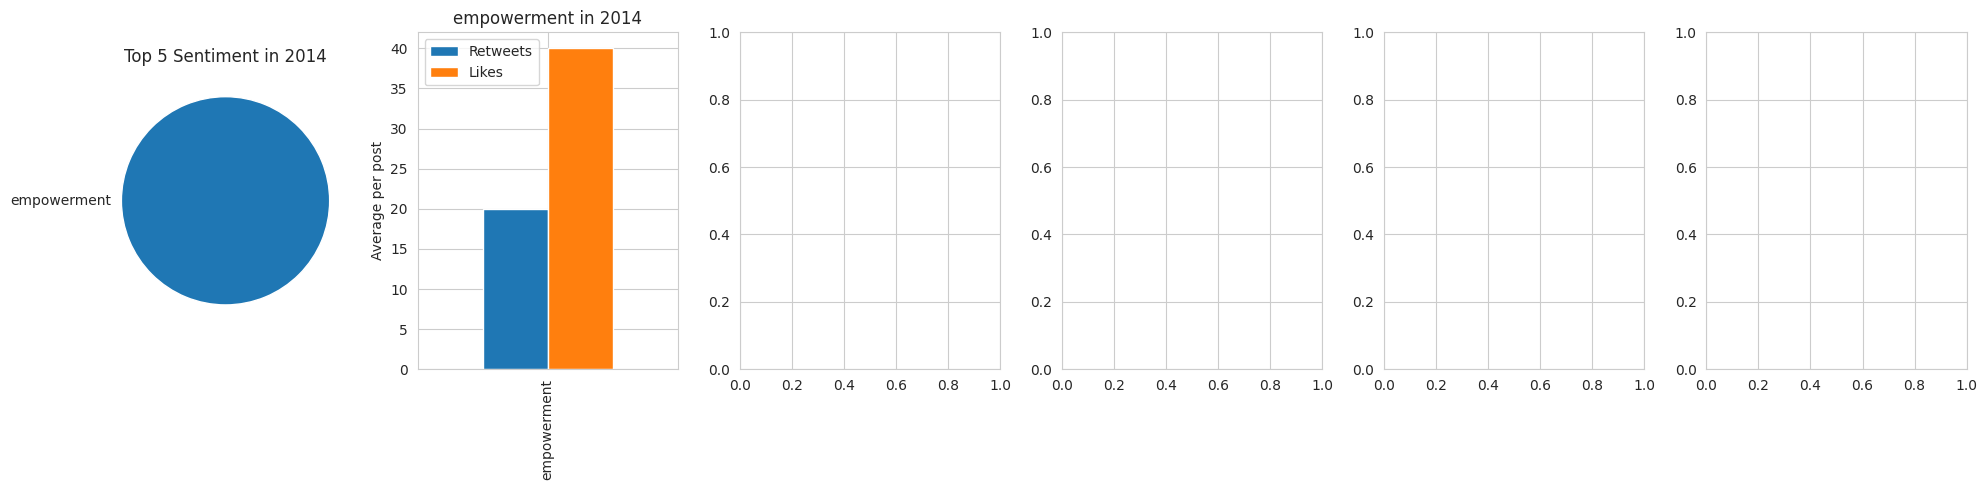

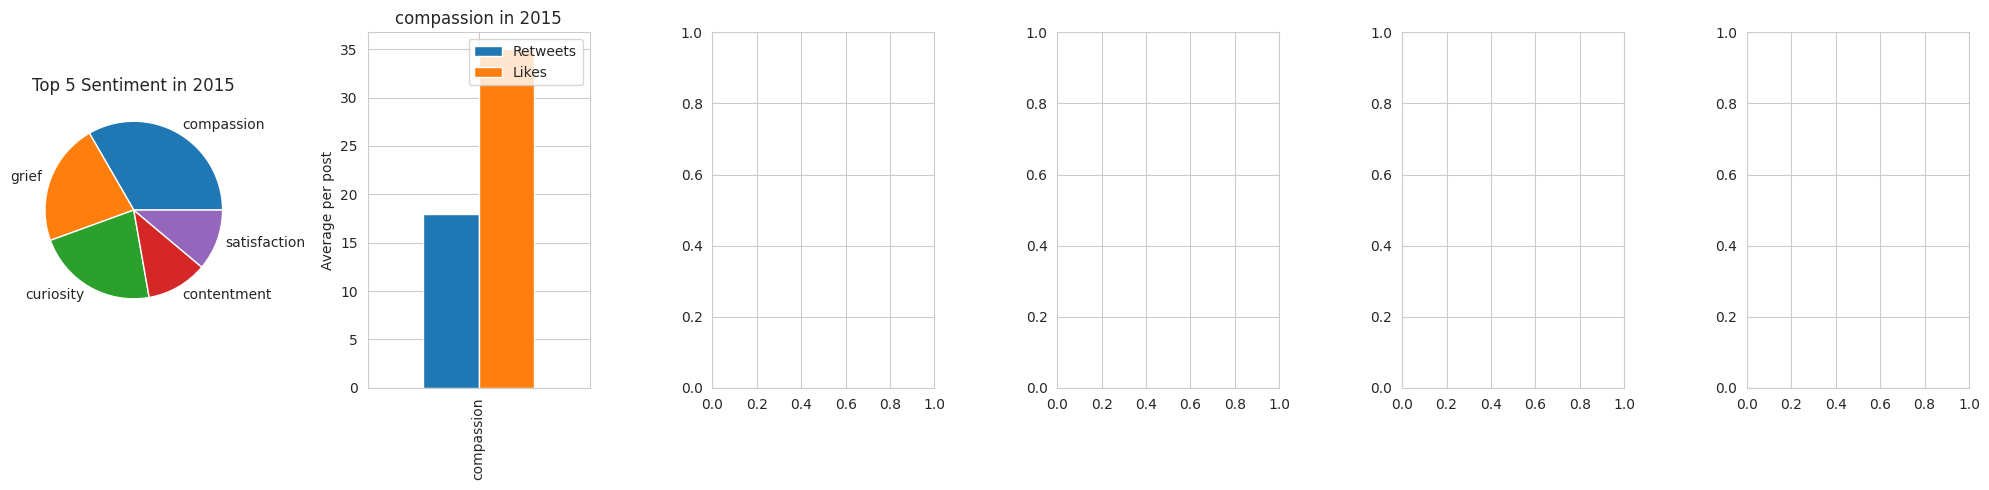

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

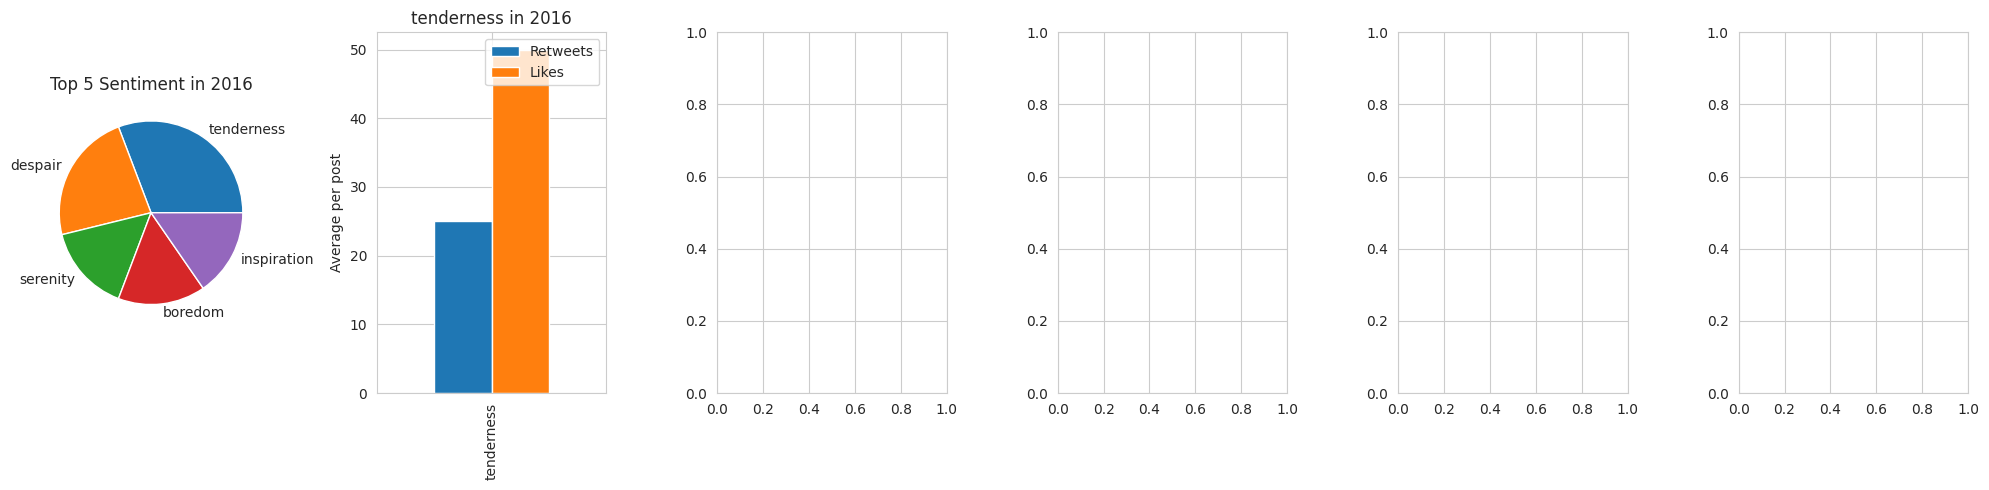

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

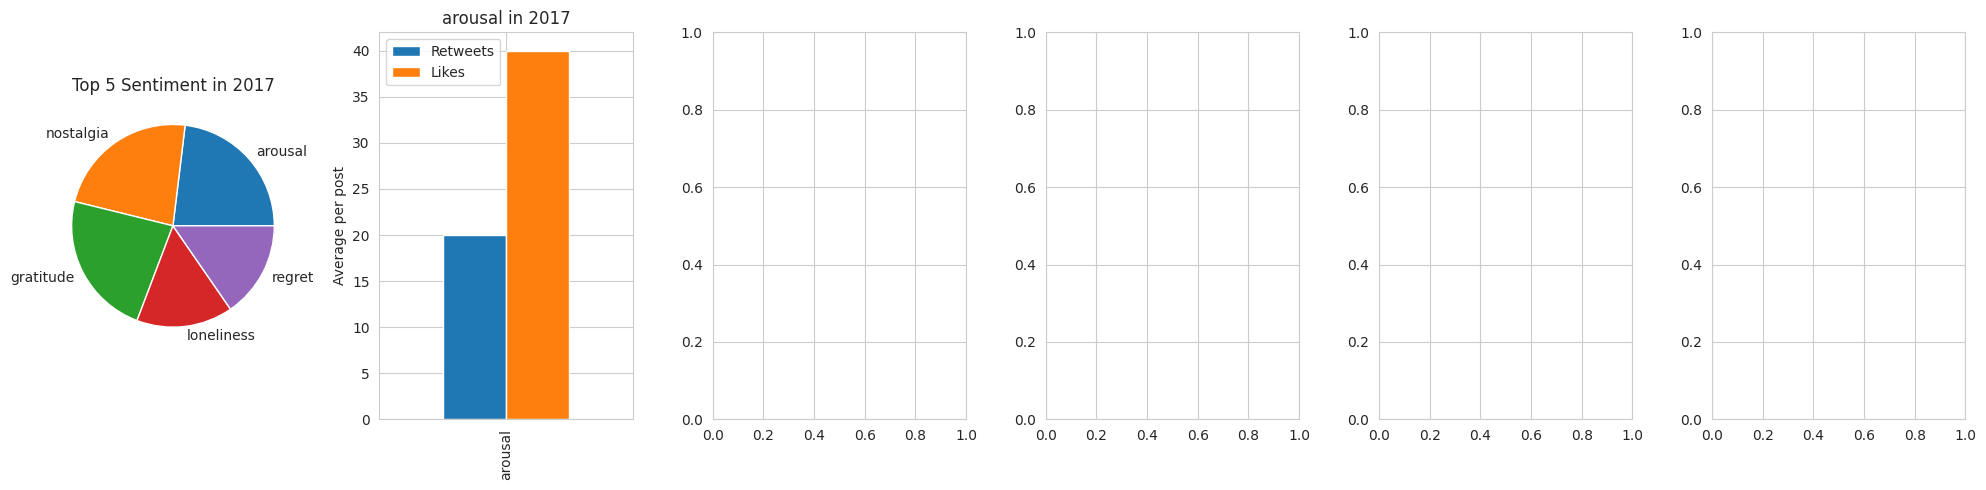

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

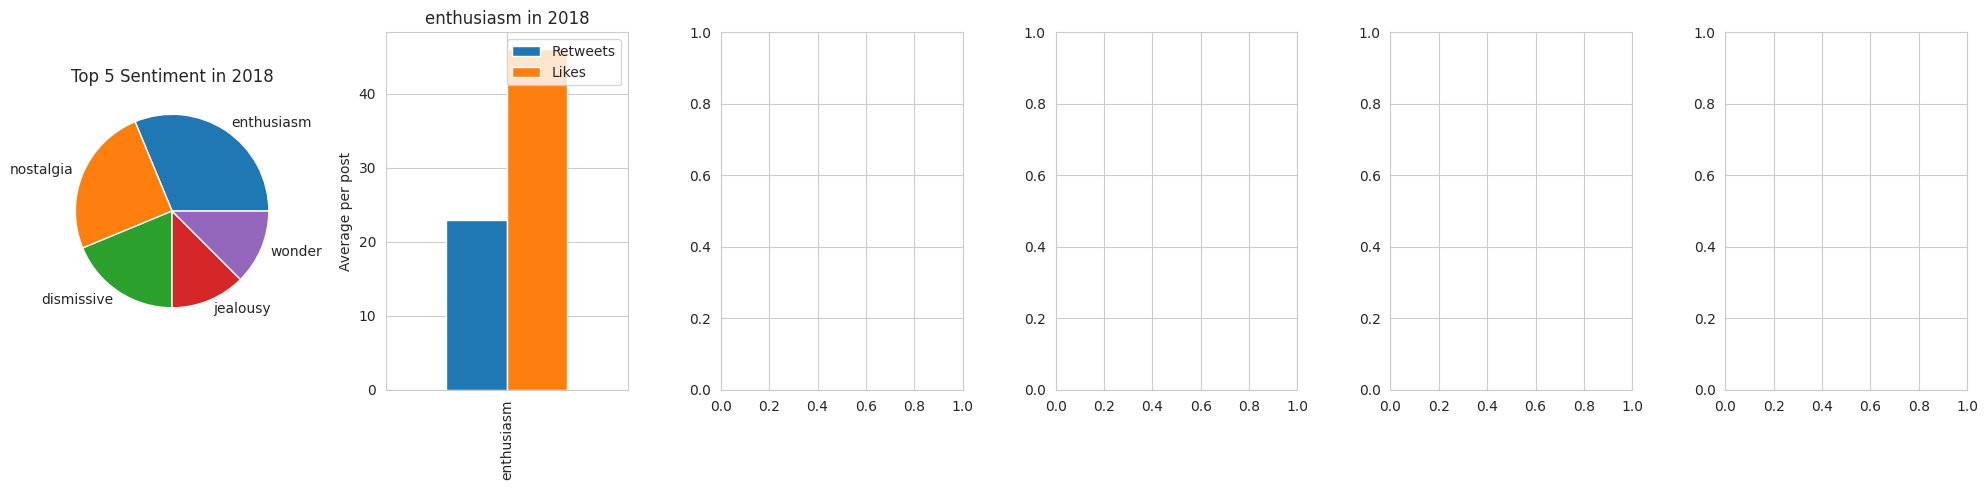

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

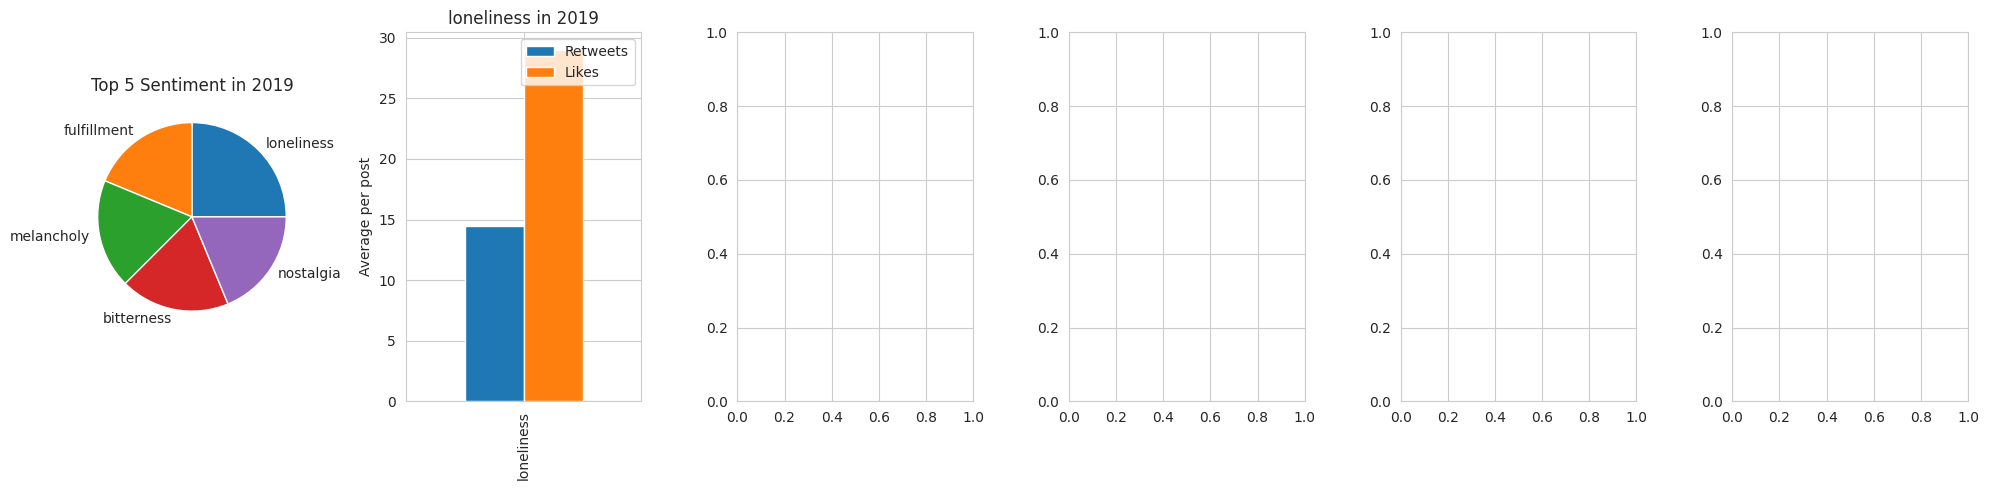

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

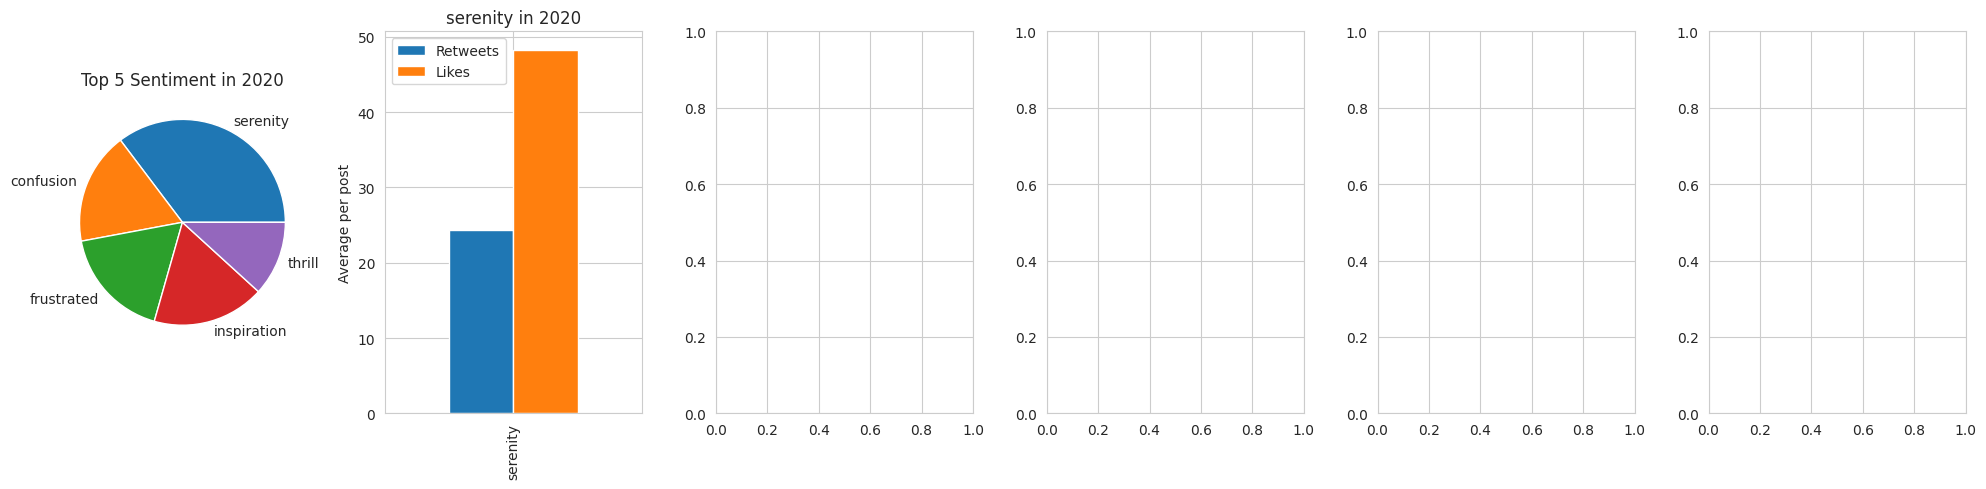

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

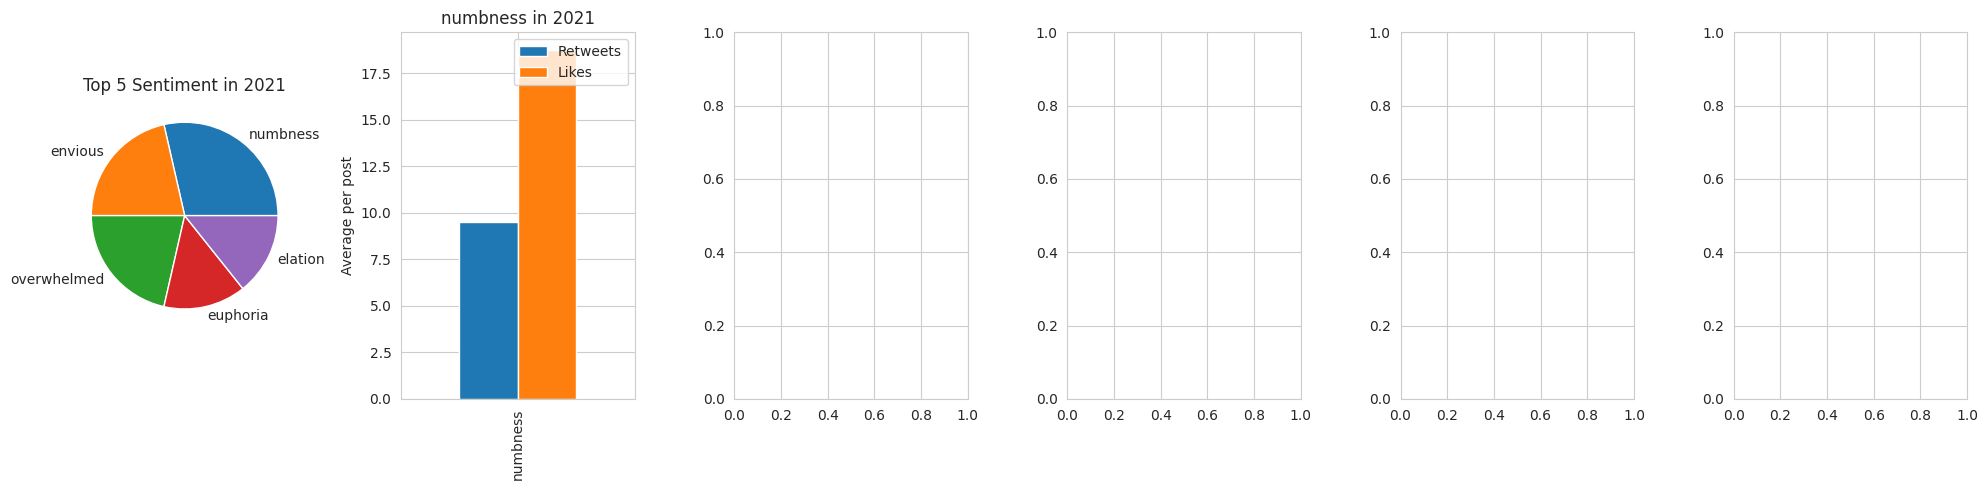

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

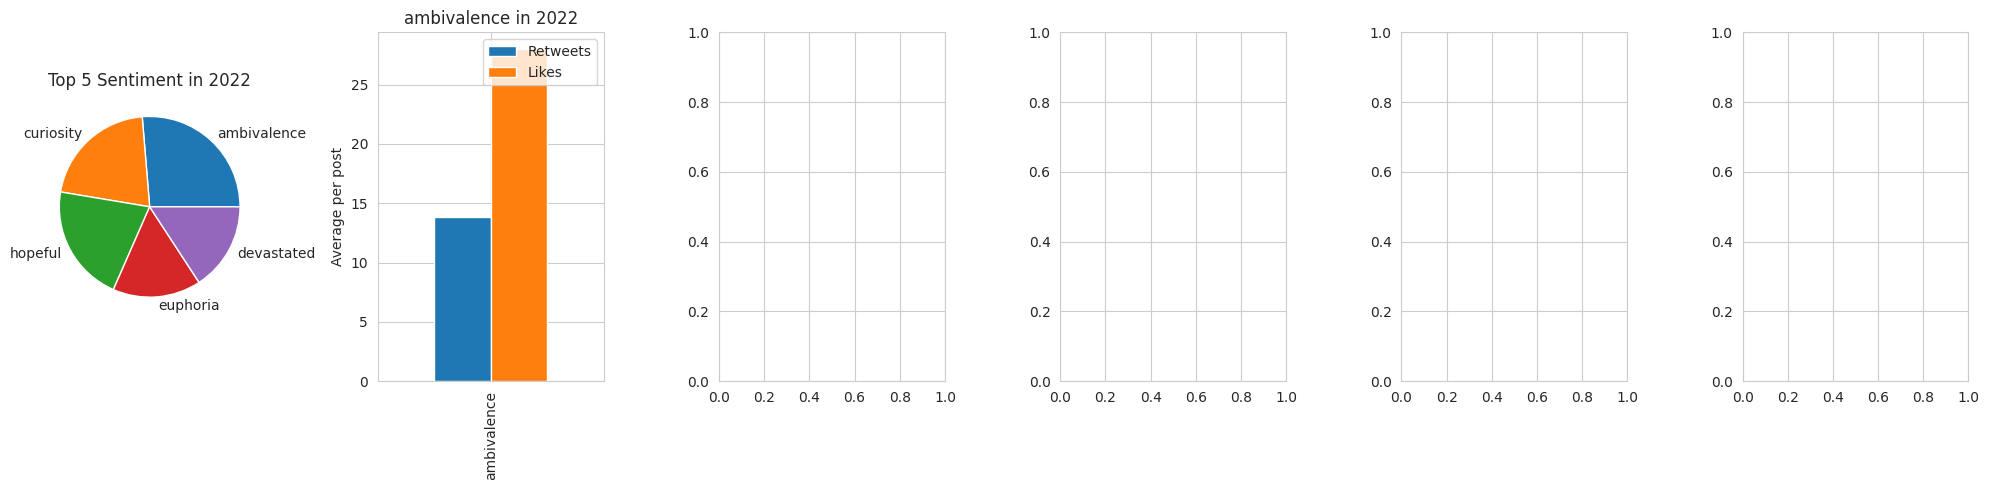

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

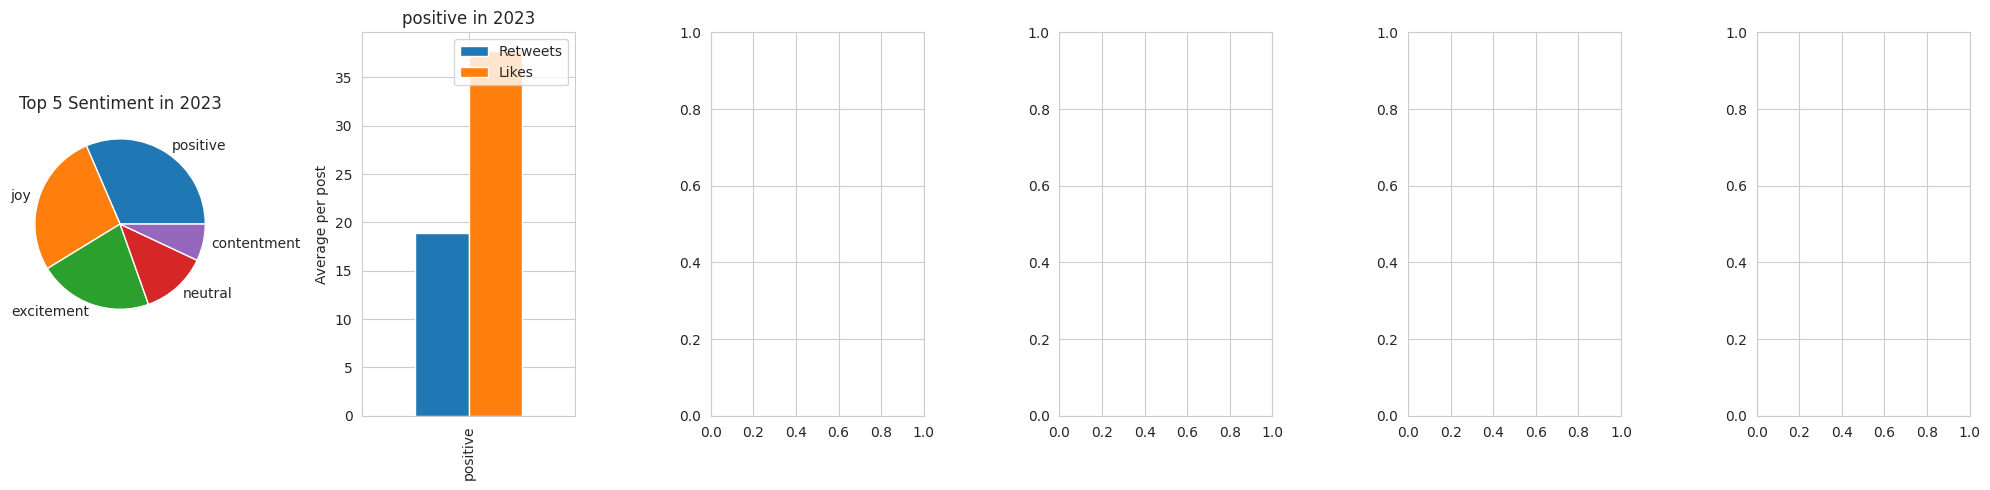

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
# draw several plots to visualize top 5 sentiment in each year, along with their numbers of retweets and likes.

# step 1: sort out years as an array for filtering data
years = df3['Year'].unique()
years.sort()

# step 2: use for loop to draw sentiment distribution for each year in chronological order
for year in years:
    # filter out top 5 sentiments in each year using value_counts
    top_5_sentiment_yr = df3[df3['Year'] == year]['Sentiment'].value_counts().head(5)
    # design the basic layout
    fig, ax = plt.subplots(1, 6, figsize=(20, 5))
    # draw pie chart for top 5 sentiment distribution
    top_5_sentiment_yr.plot(kind='pie', ax=ax[0])
    ax[0].set_title(f'Top 5 Sentiment in {year}')
    ax[0].set_ylabel('')
    # group by each sentiment and calculate the average of retweets and likes
    for i, sentiment in enumerate(top_5_sentiment_yr.index):
        sentiment_group = df3[(df3['Year'] == year) & (df3['Sentiment'] == sentiment)].groupby('Sentiment')[['Retweets', 'Likes']].mean().plot(kind='bar', ax=ax[i+1])
        ax[i+1].set_title(f'{sentiment} in {year}')
        ax[i+1].set_xlabel('')
        ax[i+1].set_ylabel('Average per post')
        plt.tight_layout()
        plt.show()


According to these graphs, I notice two trends:
1. In the 2010-2015, positive sentiments dictate social media posts, up until 2016.
2. As time progresses, sentiments are becoming more diversifed, and negative sentiments start to gain popularity since 2016,
 <br>(This observation can be flawed due to the time imbalance in this dataset)
3. The average number of likes is greater than the average number of retweets, and both figues stay stable over the years.

Posts identified with major 5 sentiments in 2023 accounts for almost 46% (131/287) posts in 2023

## Sentiment Platform Analysis
<br>Is this dataset representative of sentiments across major platforms?

In [ ]:
# find the most popular platforms, and make sure each platform is only counted once
df3['Platform'].value_counts()

,count
Platform,
instagram,252
twitter,236
facebook,224


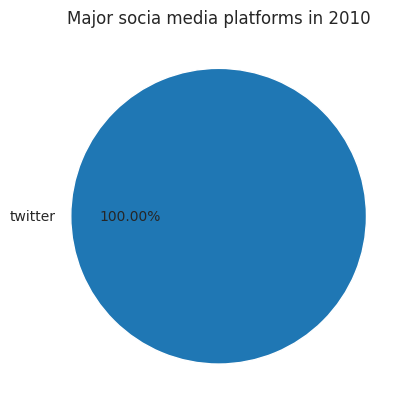

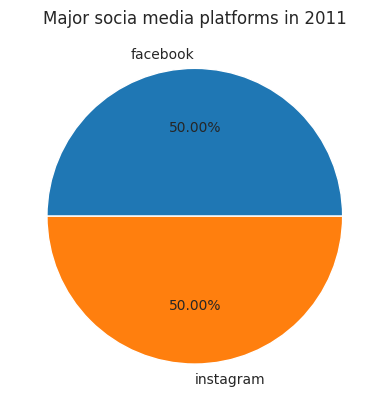

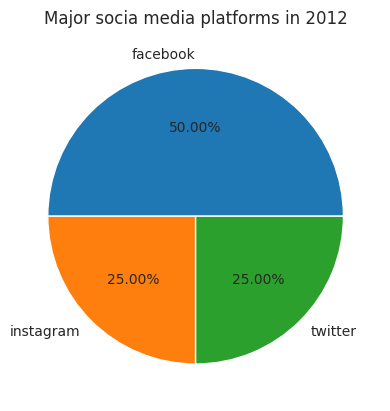

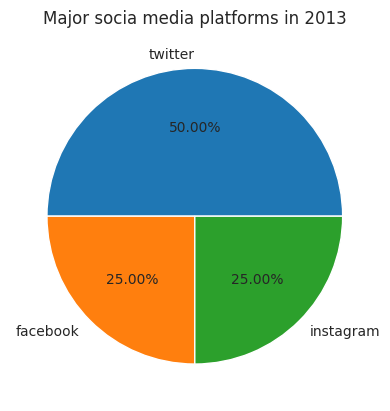

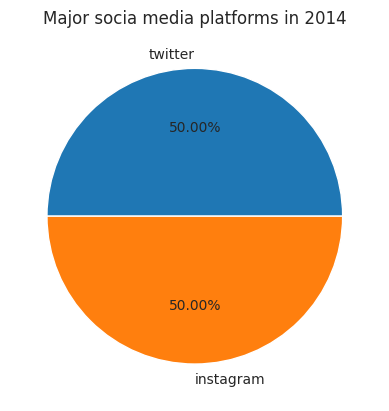

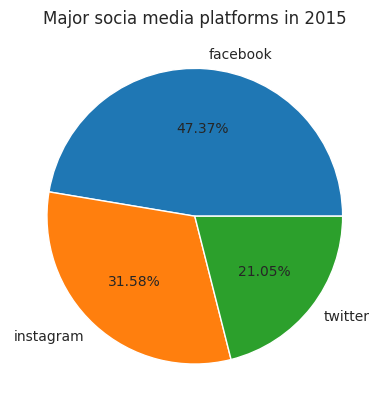

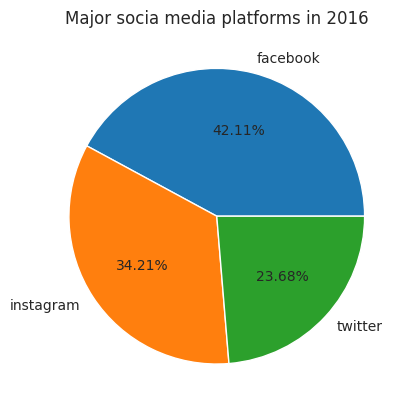

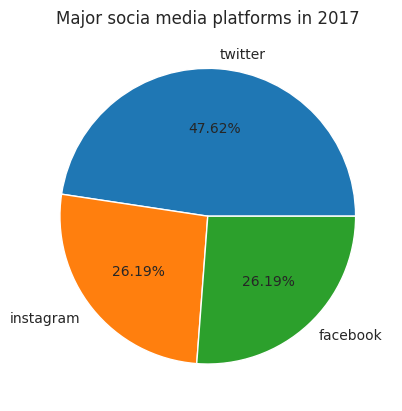

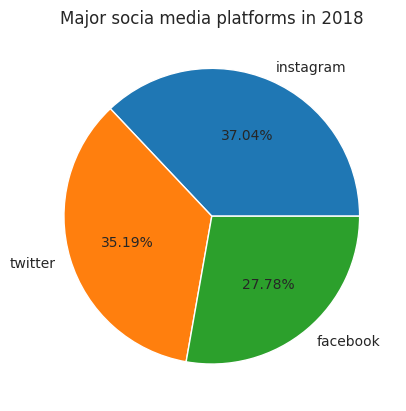

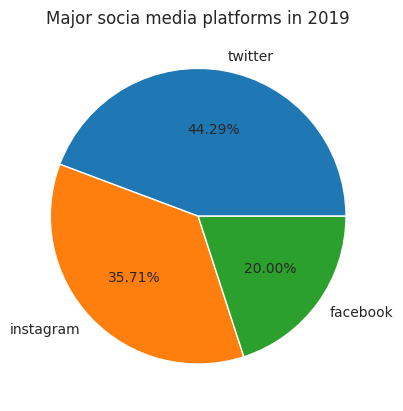

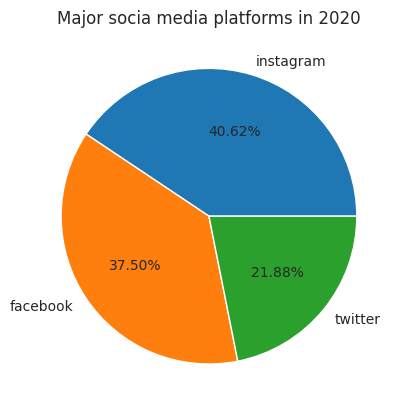

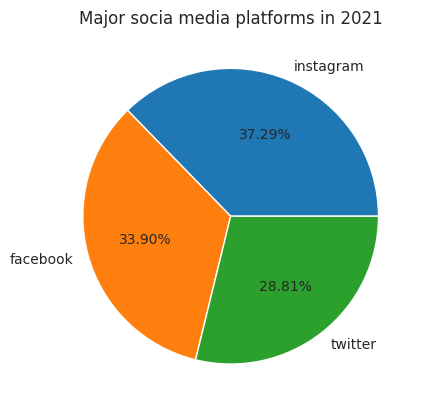

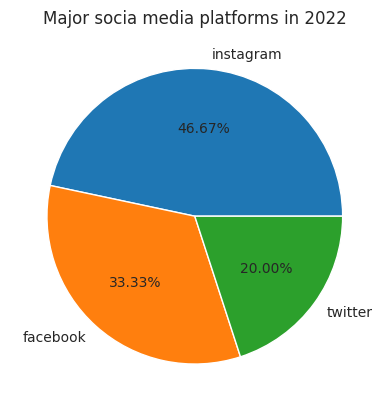

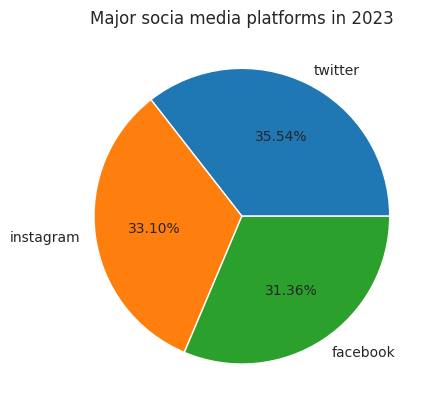

In [ ]:
# use for loop to find major social media platforms for each year
for year in years:
    df3[df3['Year'] == year]['Platform'].value_counts().plot(kind='pie', autopct='%.2f%%')
    plt.title(f'Major socia media platforms in {year}')
    plt.ylabel('')
    plt.show()

Noticed Instagram did not emerge until 2011, <br>Despite the overall imbalance in time,
 this dataset is balanced in sampling from three major social media sites in each year.

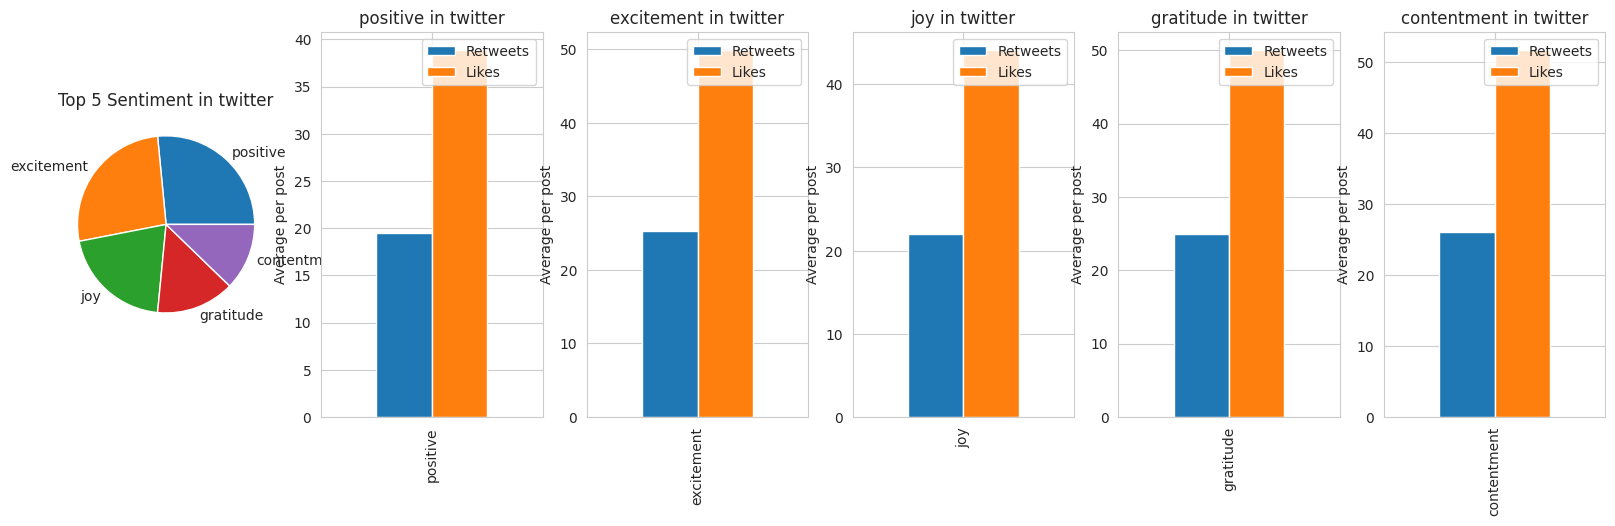

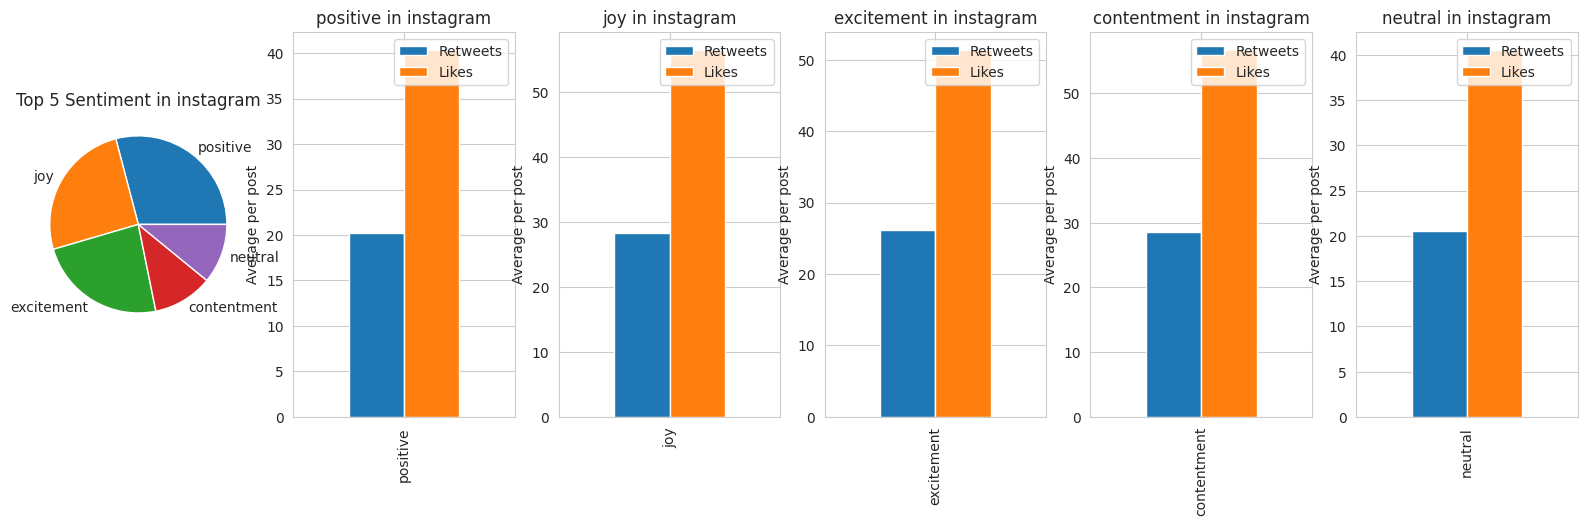

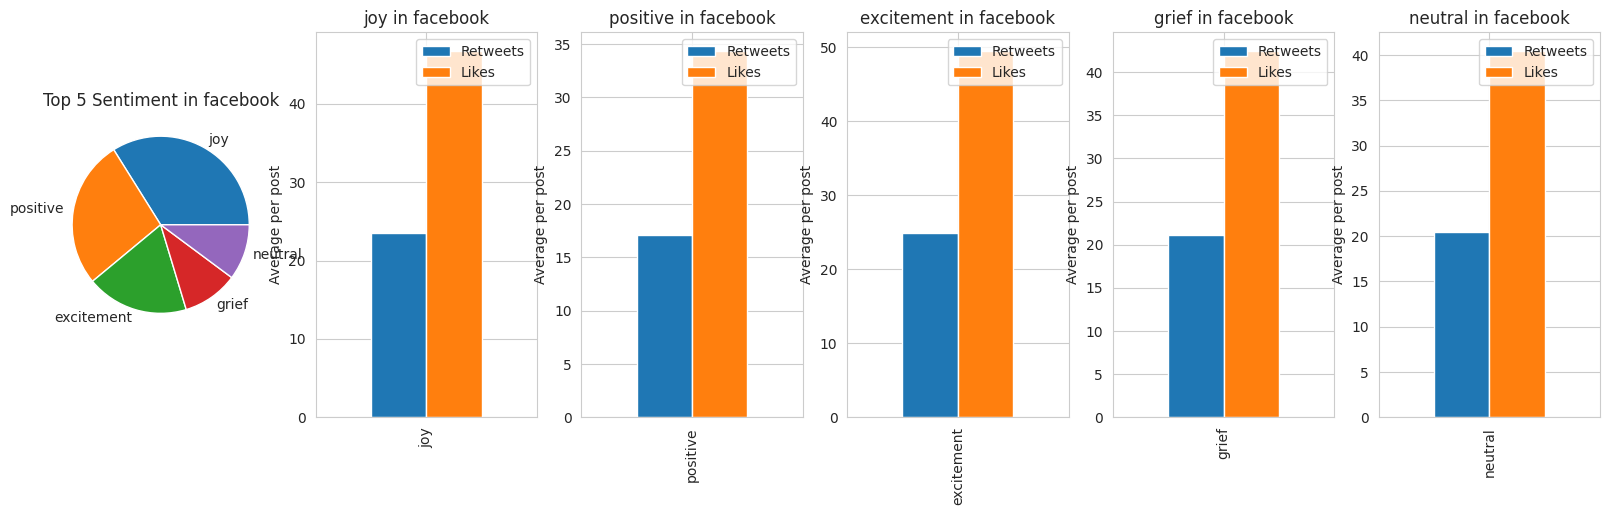

In [ ]:
# for each platform, find the top 5 sentiments and their average retweets and likes

# step 1: sort out years as an array for filtering data
platforms = df3['Platform'].unique()

# step 2: use for loop to draw sentiment distribution for each year in chronological order
for platform in platforms:
    # filter out top 5 sentiments in each year using value_counts
    top_5_sentiment_pf = df3[df3['Platform'] == platform]['Sentiment'].value_counts().head(5)
    # design the basic layout
    fig, ax = plt.subplots(1, 6, figsize=(20, 5))
    # draw pie chart for top 5 sentiment distribution
    top_5_sentiment_pf.plot(kind='pie', ax=ax[0])
    ax[0].set_title(f'Top 5 Sentiment in {platform}')
    ax[0].set_ylabel('')
    # group by each sentiment and calculate the average of retweets and likes
    for i, sentiment in enumerate(top_5_sentiment_pf.index):
        sentiment_group = df3[(df3['Platform'] == platform) & (df3['Sentiment'] == sentiment)].groupby('Sentiment')[['Retweets', 'Likes']].mean().plot(kind='bar', ax=ax[i+1])
        ax[i+1].set_title(f'{sentiment} in {platform}')
        ax[i+1].set_xlabel('')
        ax[i+1].set_ylabel('Average per post')

## Sentiment Country Analysis

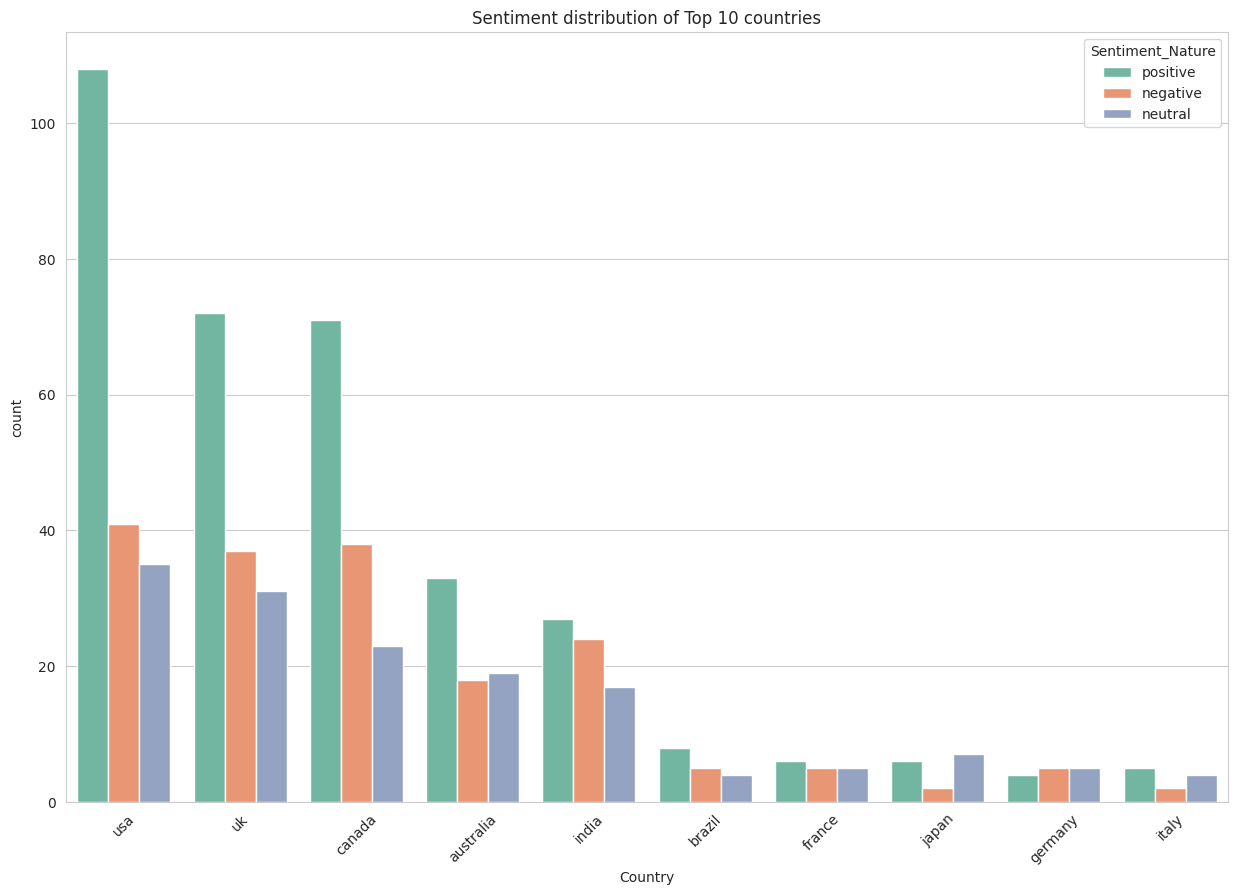

In [ ]:
# visualize sentiment distribution for each country
plt.figure(figsize=(15, 10))
sns.countplot(x='Country', data=df3, order=df3['Country'].value_counts().index[:10], palette='Set2', hue='Sentiment_Nature')
plt.xticks(rotation=45)
plt.xlabel('Country')
plt.title('Sentiment distribution of Top 10 countries')
plt.savefig('/content/drive/MyDrive/sentiment_distribution_country.png')
plt.show()


## Sentiment Nativity Analysis

As a foreigner, I personally tend to express positivity when I speak a foreign language, and since all posts are written in English, will nativity of English affect the sentiment distribution?

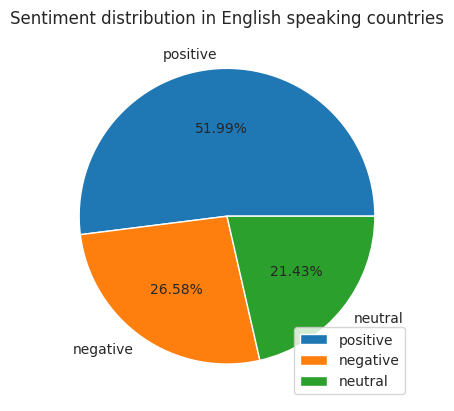

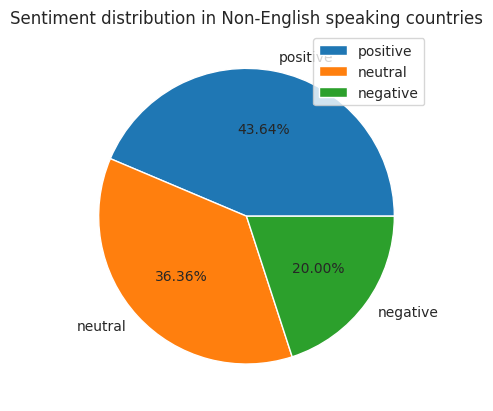

In [ ]:
# group countries into 'English' and 'Non-English', and find out their sentiment distribution
# create a list of English-speaking countries
english_countries = ['usa', 'uk', 'canada', 'australia', 'india', 'south africa', 'ireland', 'scotland']
# create a new column 'English' to indicate whather this post come from a Native English speaking country
df3['Native Language'] = df3['Country'].apply(lambda x: 'English' if x in english_countries else 'Non-English')
# sentiment_data['Native Language'].value_counts()
# draw pie charts to compare sentiment distribution in English country and non-English country posts
for language in df3['Native Language'].unique():
    df3[df3['Native Language'] == language]['Sentiment_Nature'].value_counts().plot(kind='pie', autopct='%.2f%%')
    plt.title(f'Sentiment distribution in {language} speaking countries')
    plt.ylabel('')
    plt.legend(loc='best')
    plt.show()

Contrary to my original assumption, there is no major difference in the sentiment composition between native speaker posts and non-native speaker posts. <br><br>However, some posts are labeled inappropriately based on our sentiment-nature analysis, which can lead to an overestimation of 'neutral' sentiments, <br>especially in non-English speaking countries.

## Correlation Analysis

Now we want to take a further step to analyze the correlation between some attributes thet we have explored in the EDA stage, and compute a numeric result.
<br><br>Especially in the following ways:
1. Find out how year, platform, and country impact sentiment scores of the social media posts.
2. Find out which type of sentiment tend to get more reposts & likes. <br>Does positive posts tend to get more retweets and likes? <br>What about neutral posts and negative posts?

### Find out the correlation between 'Sentiment_Score' and 'Year', 'Platform', and 'Native Language'

In [ ]:
# create a new df for coorelation analysis
trim_data_1 = df3[['Sentiment_Nature', 'Platform', 'Native Language', 'Year']]
trim_data_1.head()

,Sentiment_Nature,Platform,Native Language,Year
id,,,,
0,positive,twitter,English,2023
1,negative,twitter,English,2023
2,positive,instagram,English,2023
3,positive,facebook,English,2023
4,neutral,instagram,English,2023


In [ ]:
# use pd.get_dummies to categorize columns
dummy_data_1 = pd.get_dummies(data=trim_data_1)
dummy_data_1.head()

,Year,Sentiment_Nature_negative,Sentiment_Nature_neutral,Sentiment_Nature_positive,Platform_facebook,Platform_instagram,Platform_twitter,Native Language_English,Native Language_Non-English
id,,,,,,,,,
0,2023,False,False,True,False,False,True,True,False
1,2023,True,False,False,False,False,True,True,False
2,2023,False,False,True,False,True,False,True,False
3,2023,False,False,True,True,False,False,True,False
4,2023,False,True,False,False,True,False,True,False


In [ ]:
# run correlation analysis on the dummy_data
corr_matrix_1 = dummy_data_1.corr()
# see only the correlation between 'Sentiment_Nature' and other columns
pd.set_option('display.max_rows', None)
print("\033[1mPositive Sentiment Correlation:\033[0m")
print(f"{corr_matrix_1['Sentiment_Nature_positive'].sort_values(ascending=False)}\n")
print("\033[1mNeutral Sentiment Correlation:\033[0m")
print(f"{corr_matrix_1['Sentiment_Nature_neutral'].sort_values(ascending=False)}\n")
print("\033[1mNegative Sentiment Correlation:\033[0m")
print(f"{corr_matrix_1['Sentiment_Nature_negative'].sort_values(ascending=False)}")

Positive Sentiment Correlation:
Sentiment_Nature_positive      1.000000
Year                           0.155176
Native Language_English        0.060414
Platform_facebook              0.032832
Platform_instagram             0.001353
Platform_twitter              -0.033762
Native Language_Non-English   -0.060414
Sentiment_Nature_neutral      -0.565775
Sentiment_Nature_negative     -0.594289
Name: Sentiment_Nature_positive, dtype: float64

Neutral Sentiment Correlation:
Sentiment_Nature_neutral       1.000000
Native Language_Non-English    0.126870
Platform_instagram             0.015086
Platform_twitter               0.006894
Platform_facebook             -0.022525
Native Language_English       -0.126870
Year                          -0.195594
Sentiment_Nature_negative     -0.326920
Sentiment_Nature_positive     -0.565775
Name: Sentiment_Nature_neutral, dtype: float64

Negative Sentiment Correlation:
Sentiment_Nature_negative      1.000000
Native Language_English        0.054503
Platform

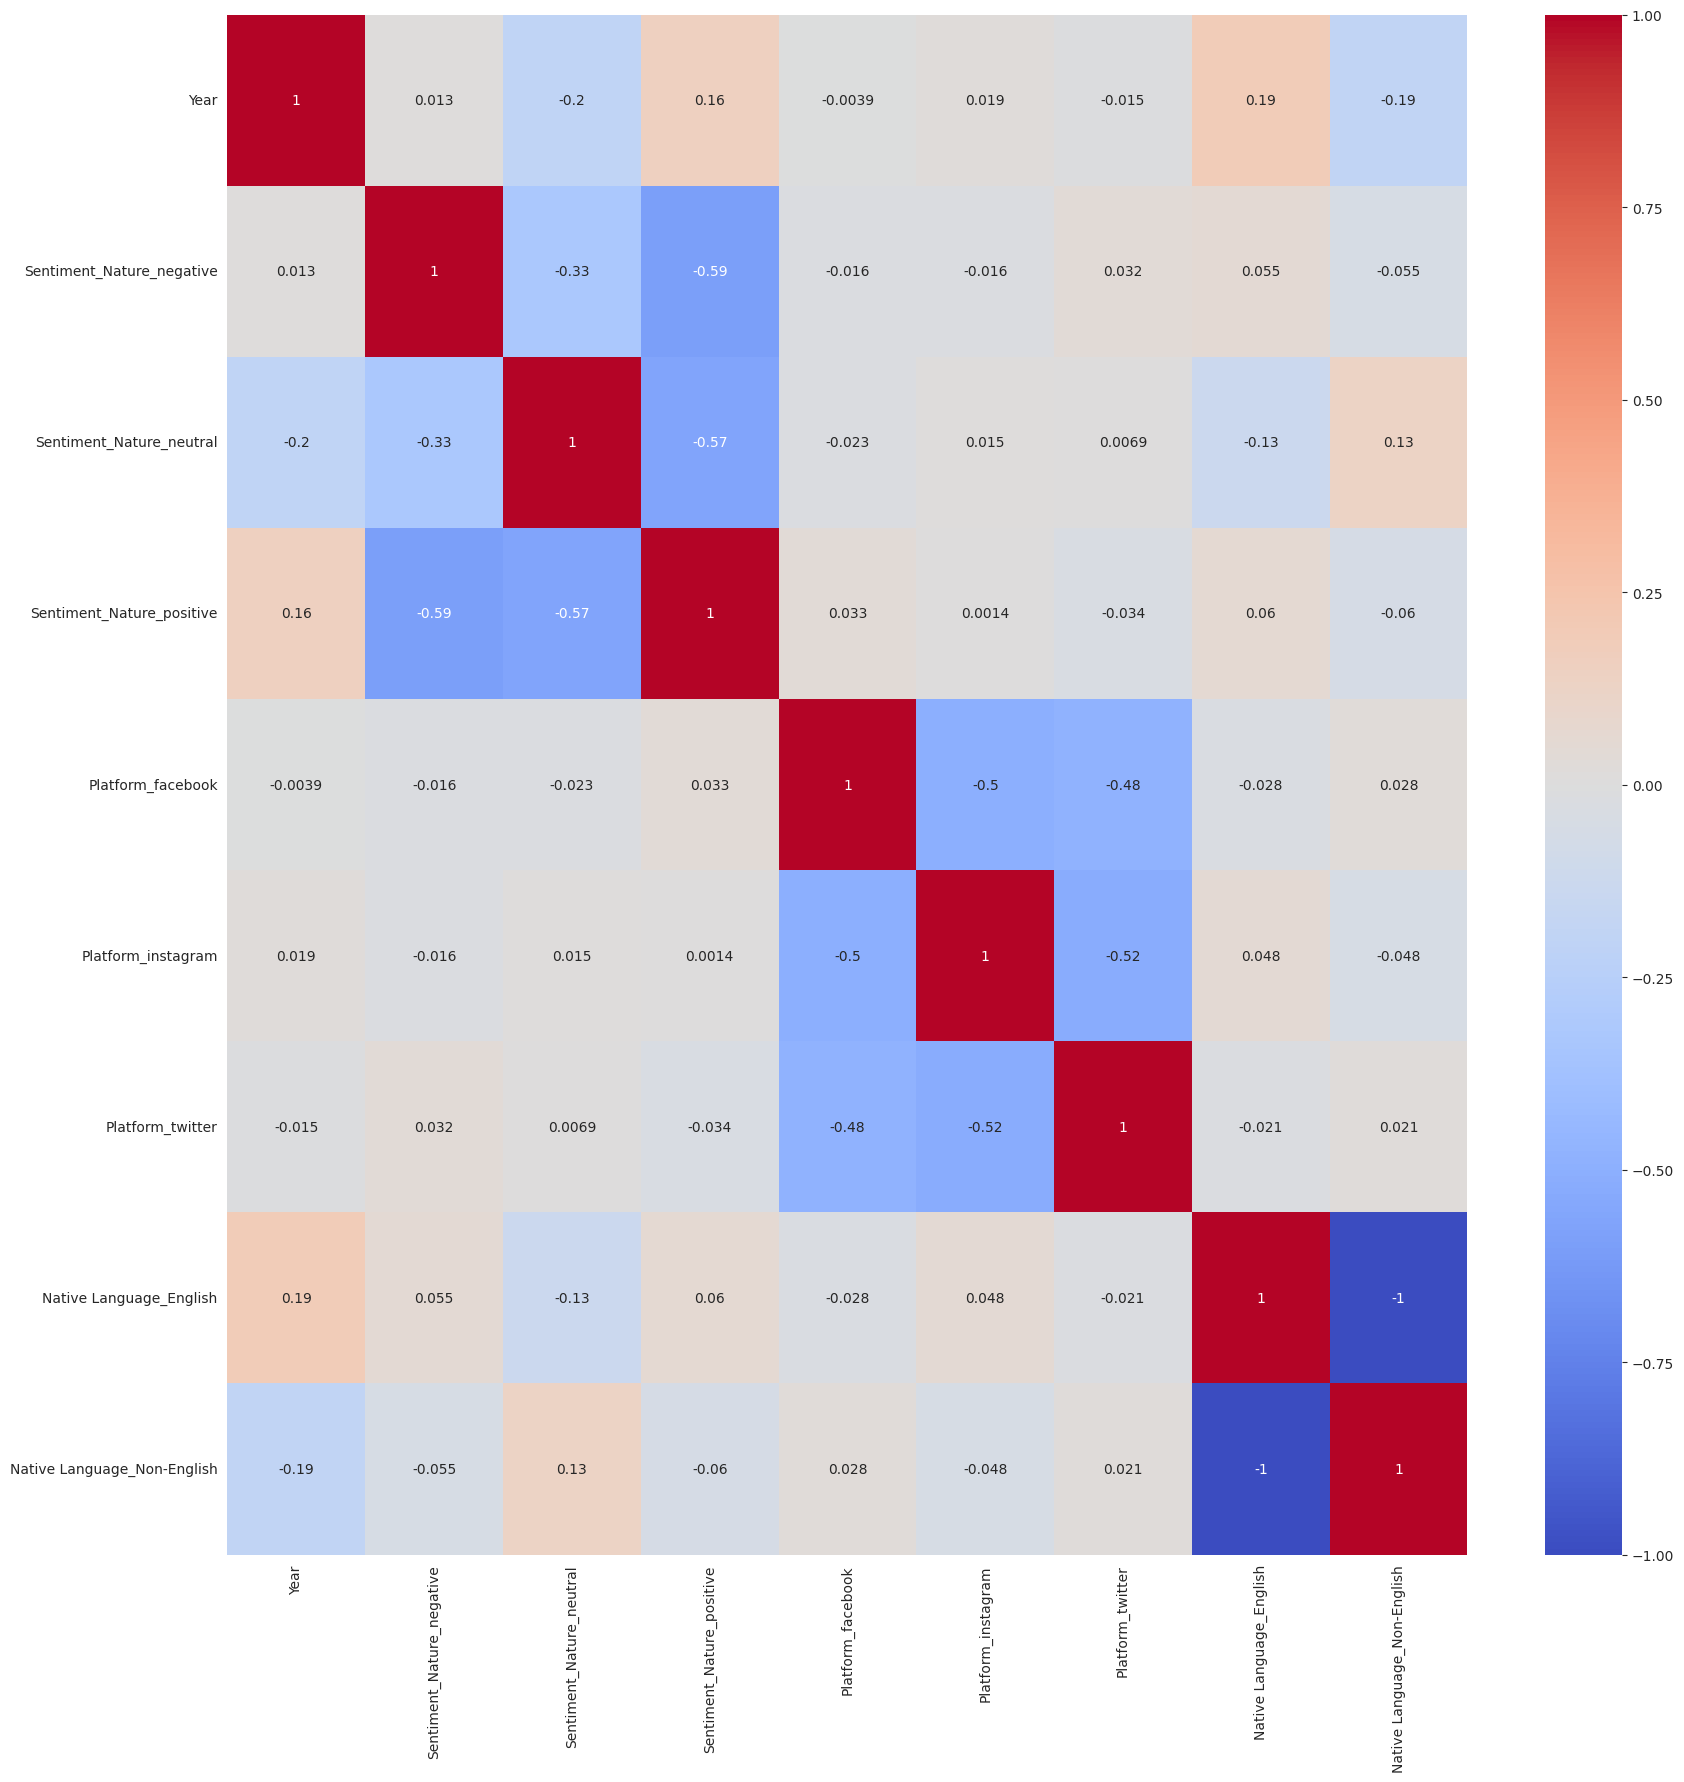

In [ ]:
# visualize the correlation matrix using heatmap
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix_1, cmap='coolwarm', annot=True)
plt.savefig('/content/drive/MyDrive/correlation_on_sentiments_to_other_impact.png')

Based on the correlation analysis, it is interesting to see:
1. *Positive* posts are more time-sensitive, and becoming more positive over the year.
2. *Neutral* posts are more language-sensitive, where **non-English speaker** tend to write neutral posts, which might be due to the language barrier, or mislabeling in sentiments.
3. On the other hand, *negative* posts are more language-sensitive, in terms of having **English speaker** writing negiva posts, which might be due to the tendency to express negative feelings in native language.

### Sentiment Correltion with Retweets & Likes

In [ ]:
# create a correlation matrix for sentiment natures and reposts & likes
trim_data_2 = df3[['Sentiment_Nature', 'Retweets', 'Likes']]
dummy_data_2 = pd.get_dummies(data=trim_data_2)
corr_matrix_2 = dummy_data_2.corr()

pd.set_option('display.max_rows', None)
print("\033[1mPositive Sentiment Correlation:\033[0m")
print(f"{corr_matrix_2['Sentiment_Nature_positive'].sort_values(ascending=False)}\n")
print("\033[1mNeutral Sentiment Correlation:\033[0m")
print(f"{corr_matrix_2['Sentiment_Nature_neutral'].sort_values(ascending=False)}\n")
print("\033[1mNegative Sentiment Correlation:\033[0m")
print(f"{corr_matrix_2['Sentiment_Nature_negative'].sort_values(ascending=False)}")

Positive Sentiment Correlation:
Sentiment_Nature_positive    1.000000
Retweets                     0.208841
Likes                        0.206684
Sentiment_Nature_neutral    -0.565775
Sentiment_Nature_negative   -0.594289
Name: Sentiment_Nature_positive, dtype: float64

Neutral Sentiment Correlation:
Sentiment_Nature_neutral     1.000000
Likes                        0.109842
Retweets                     0.108669
Sentiment_Nature_negative   -0.326920
Sentiment_Nature_positive   -0.565775
Name: Sentiment_Nature_neutral, dtype: float64

Negative Sentiment Correlation:
Sentiment_Nature_negative    1.000000
Sentiment_Nature_neutral    -0.326920
Likes                       -0.344023
Retweets                    -0.345352
Sentiment_Nature_positive   -0.594289
Name: Sentiment_Nature_negative, dtype: float64


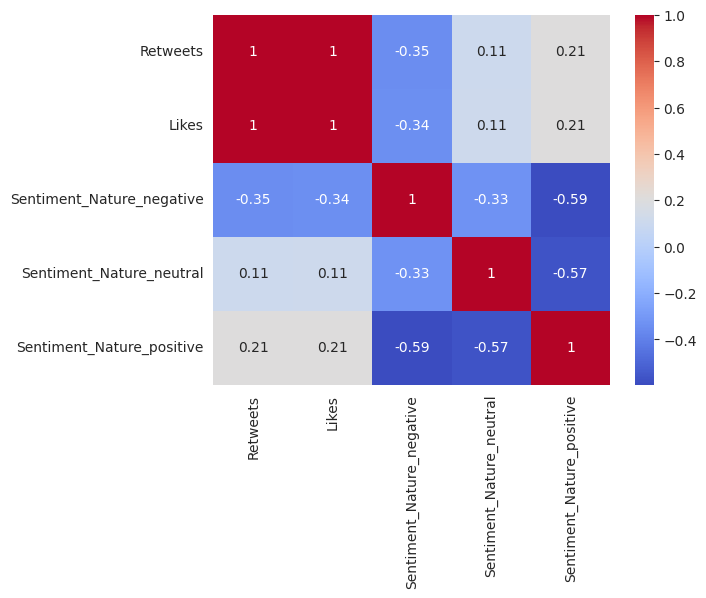

In [ ]:
sns.heatmap(corr_matrix_2, cmap='coolwarm', annot=True)
plt.savefig('/content/drive/MyDrive/correlation_on_sentiments_to_retweets_and_likes.png')

Based on the correlation analysis, it is interesting to see:
<br>
1. *Positive* posts tend to get more retweets and likes, which validate our hypothesis.
2. *Neutral* posts have tend to get less retweets and likes, but they are still positively correlated.
3. *Negative* posts shows all negative coorelation, which shows that negative posts do not tend to get more likes and retweets.